# Project Information

In this project, I will take a look at the Stroke Prediction Dataset (2021) in the context of a Final Assignment for a Machine Learning class.
The dataset consists of possible health and socioeconomic factors regarding stroke events, such as BMI and residence type.
We will first take a look at the dataset and it's variables before going into some data exploration and preprocessing.
After we gained a good overview of our data, we will choose three different Machine Learning models based on what we want to learn form our data.
Once we trained, tested and evaluated them we will compare their performance and draw some conclusions before ending with recommedations and some final thoughts on the data, model and process.

Now, come along!

# Prelude to Peril - Installing Packages and Libraries

Here, we keep our necessary libraries and packages neatly sorted.

In [3]:
# Installting necessary libraries

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Miscellaneous (for display in Jupyter)
from IPython.display import display, HTML

# Data handling and manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical analysis
import math
import scipy.stats as stats
from scipy.stats import uniform, randint

# Handling missing data
import miceforest as mf
from sklearn.impute import KNNImputer

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Handling imbalanced data
from imblearn.over_sampling import RandomOverSampler

# Feature selection
from sklearn.feature_selection import (
    RFE, RFECV, SelectFromModel, SelectKBest
)

# Model selection and evaluation
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV,
    RandomizedSearchCV, cross_val_score, StratifiedKFold
)
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report, 
    f1_score, make_scorer, recall_score, precision_recall_curve, 
    accuracy_score, roc_curve, auc, brier_score_loss
)
from sklearn.datasets import make_classification, make_regression

# Machine learning models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC, SVR


# Stoke by Stroke - Exploratory Data Analysis

In the exploratory data analysis, we want to deep dive into our data - what are the variables, what do they represent? How is our data structured, how many entries do we have?
We want to take a first look at distrubtions and data types, maybe even check for correlations or covariance where necessary.

## Taking A Look

In [6]:
# Loading the data
df = pd.read_csv("/Users/Anke Admin/Desktop/Uni/ML for Aging/healthcare-dataset-stroke-data.csv")

In [7]:
# Taking a first look at the table (variables)
pd.set_option('display.max_columns', None)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
# Shape of our dataset - how many variables, how many subjects are there?
df.shape

(5110, 12)

There are 5110 records and 12 variables in this stroke prediction dataset, containing:

- 'id',
- 'Age',
- 'Gender',
- 'Hypertension',
- 'Heart Disease',
- 'Marital Status',
- 'Work Type',
- 'Residence Type',
- 'Average Glucose Level',
- 'Body Mass Index (BMI)',
- 'Smoking Status',
- 'Stroke History'

In [10]:
# What kind of variables do we have? Continuous, categorical?
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [11]:
# Overview of descriptive statistics for our dataset variables
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


##### Comment

Taking a first look at the dataset, we can see that we have 12 variables and 5110 instances (subjects). There is an ID variable we would want to exclude, since it's only helpful to identify the person and could lead to problems in our model later on.

Afterwards, we do need to encode some of the variables which are non-numerical.

Additionally, we already see some missing values which have to be dealt with later on, accordingly, after dealing with outliers as well.
We can see a suspiciously high BMI of 97.6 for example. Also, the maximum blood glucose level (in mg/dL) should also be investigated since a blood sugar level of 271.74 mg/dL is a potentially dangerous level and especially unusual in adults without diabetes.
For now, let's take a look at our categorical variables.

In [13]:
df = df.drop('id', axis=1)

## Data Visualisation

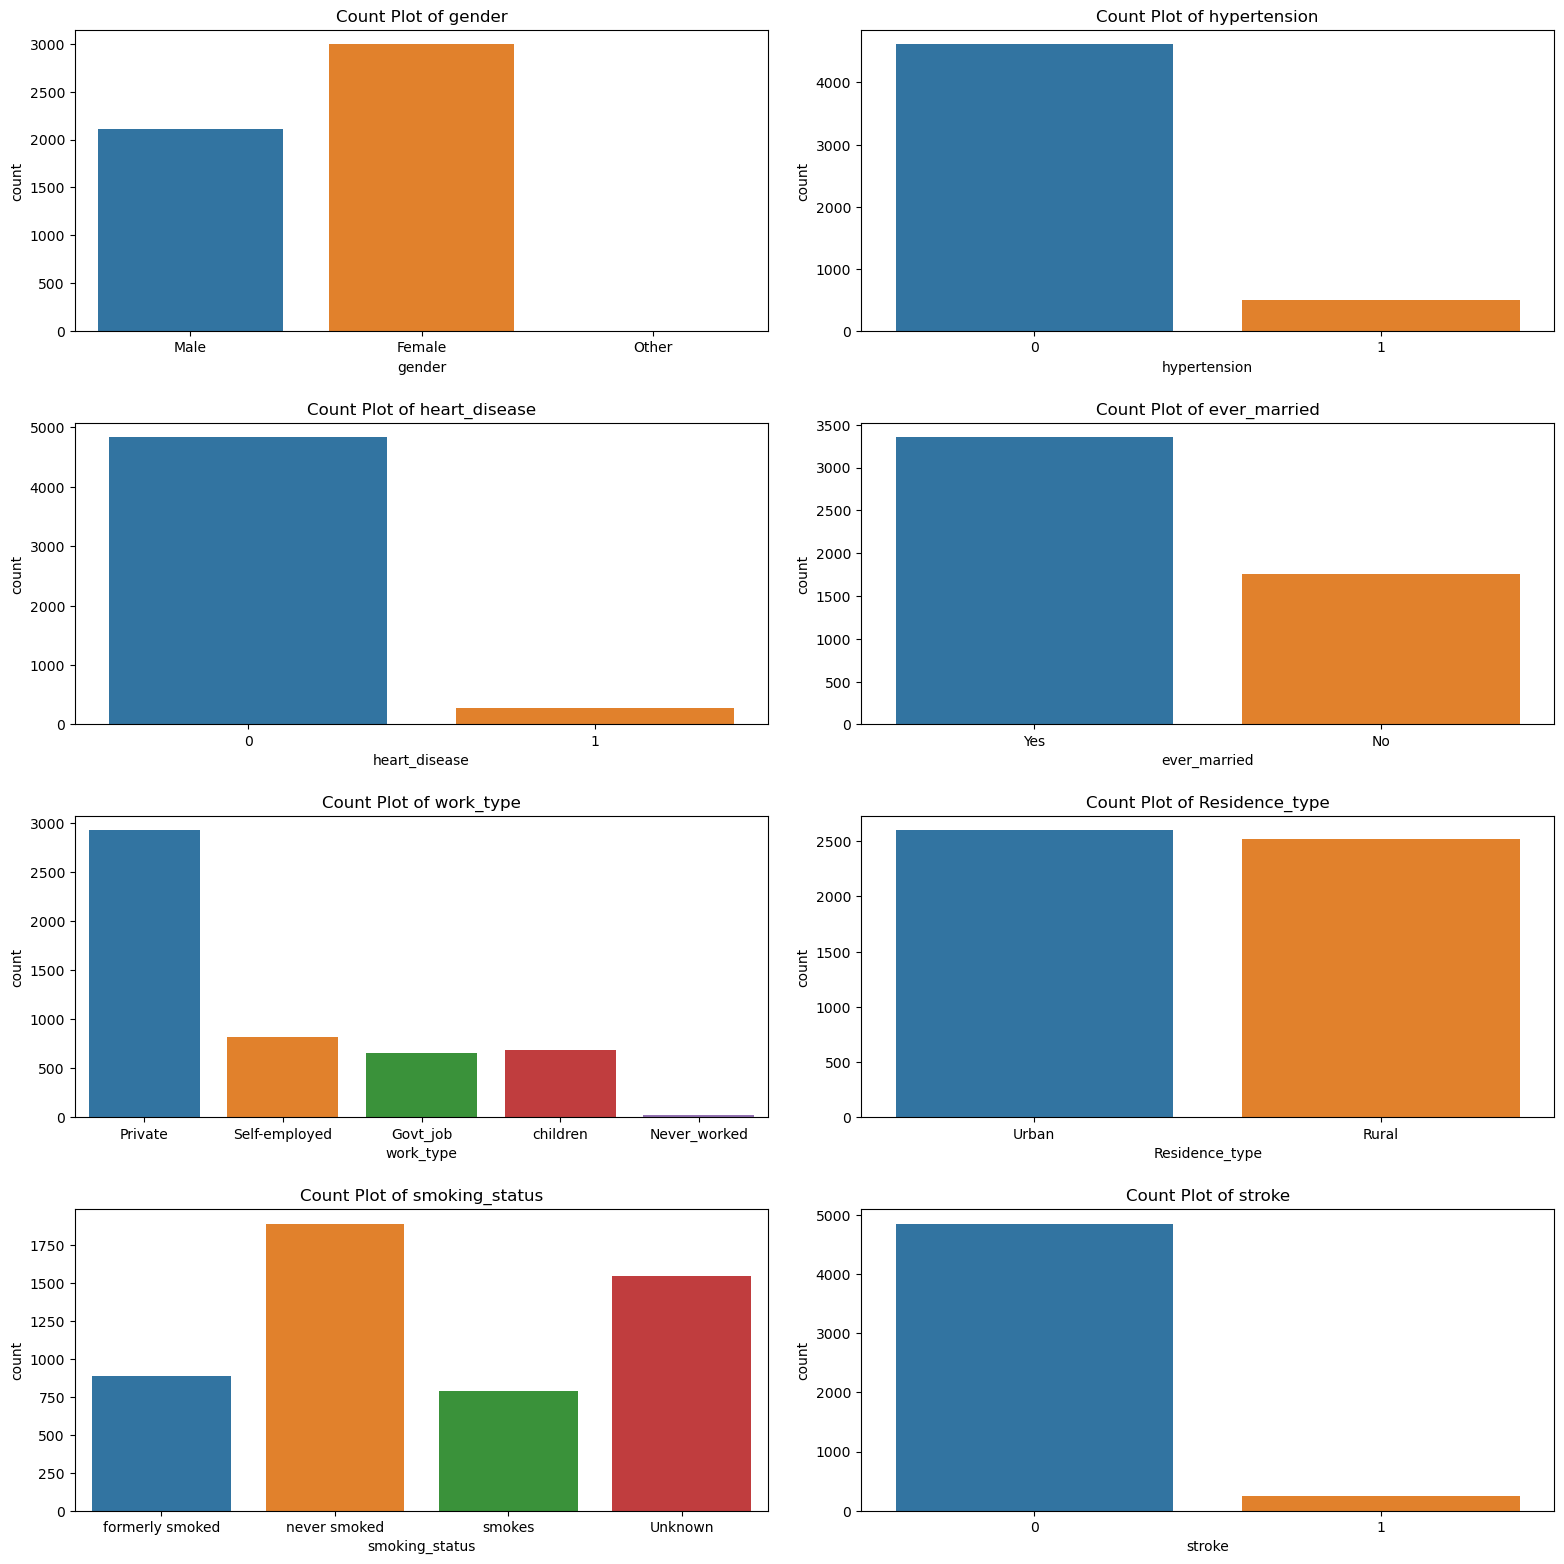

In [15]:
# Set up the number of columns and rows for subplots
df_cat = df.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)
num_cols = 2
num_rows = (len(df_cat.columns) - 1) // num_cols + 1

# Colour palette
palette = sns.color_palette(n_colors=len(df_cat.columns))

# Create a figure and axes array
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

# Iterate over each column and plot a count plot
for i, column in enumerate(df_cat.columns):
    # Calculate the row and column index for the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.countplot(x=column, data=df_cat, ax=axes[row_idx, col_idx], palette = palette)
    axes[row_idx, col_idx].set_title(f"Count Plot of {column}")

display(HTML(f"<h4>{'Countplots of categorical variables'}</h4>"))
plt.tight_layout(pad=2.0)
plt.show()


In [16]:
# Identify categorical (object) columns
df['stroke'] = df['stroke'].astype('object')

categorical_columns = df.select_dtypes(include='object').columns

# Loop through each categorical column and print value counts
for column in categorical_columns:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print()

Value counts for gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Value counts for ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

Value counts for work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Value counts for Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

Value counts for smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

Value counts for stroke:
stroke
0    4861
1     249
Name: count, dtype: int64



##### Comment
We can see that most of our categorical variables are (highly) imbalanced, especially the stroke variable which we would like to predict later on with our models. This means we should use something like SMOTE later on to deal with these imbalances.

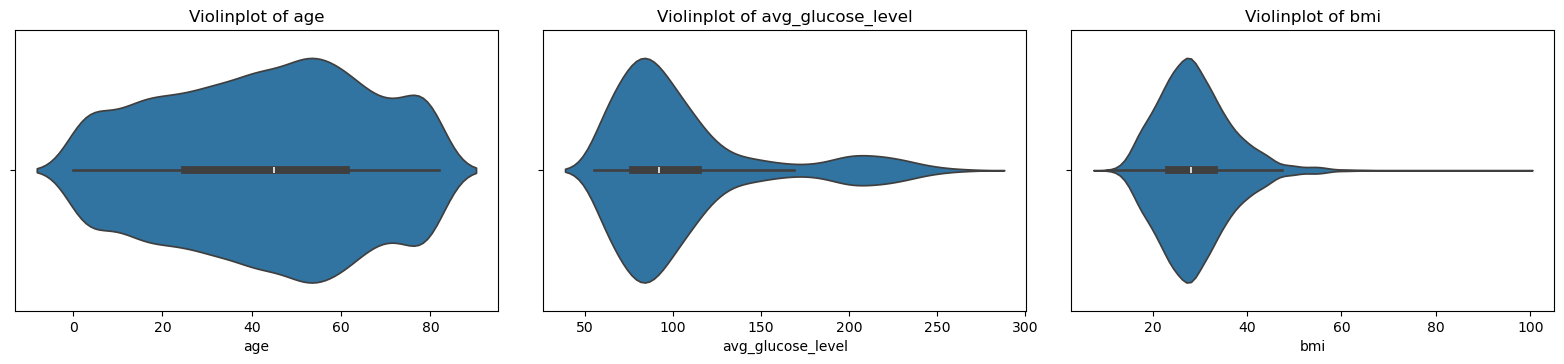

In [18]:
# Set up the number of columns and rows for subplots for our categorical variables other variables
df_metric = ['age', 'avg_glucose_level', 'bmi']

# Set up the number of columns and rows for subplots
num_cols = 3  
num_rows = 1

# Create a figure and axes array
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))

# Iterate over each column and plot a violin plot
for i, column in enumerate(df_metric):
    sns.violinplot(x=column, data=df, ax=axes[i])
    axes[i].set_title(f"Violinplot of {column}")

display(HTML(f"<h4>{'Violinplots for continuous variables'}</h4>"))
plt.tight_layout(pad=2.0)
plt.show()

In [19]:
df['bmi'].median()

28.1

In [20]:
df['age'].median()

45.0

##### Comment
We can see that we have a wide range in age for our subjects with a median of 45 years old.
Also, the median BMI for the subjects is at 28.1 which is high and on the verge of what is considered obese, yet still in line with the current american average of 29.23 (NHANES, 2023).
Most interesting is the distribution of the average glucose levels, since it shows a tendency towards a bimodal distribution. 

## Duplicates

In [23]:
# Checking for duplicates
df.duplicated(keep=False).sum()

0

## Removing Strange Data Entries 

In [25]:
# Removing the one "other" in the gender variable
df2 = df[df['gender'] != 'Other']

#Sanity Check!
print(df.shape)
print(df2.shape)

(5110, 11)
(5109, 11)


In [26]:
# Identify categorical (object) columns
# Resetting the type since we don't need it for visualisation aynmore and to proceed with coding
df2['stroke'] = df2['stroke'].astype('int64')

## Encoding 

Since most of our categorical variables are non-numerical, we want to encode them for any models we might later want to use.
Most of our variables are either binary (existing, not existing), have no inherent order (type of work) or are somewhat ordinal (smoking habit does indicate if one has smoked "more" or "less" than someone). The binary variables (hypertension, heart_disease, stroke) are already label-encoded.
Therefore we will proceed accordingly and will encode our object variables, due to missing equal magnitudes between the smoking categories and because the other variables have no inherent order, with Dummy Encoding.

In [28]:
df2.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [452]:
# List to store encoded DataFrames
encoded_dfs = []

# Loop through each column with dtype object (my categorical columns)
for col in df2.select_dtypes(include=['object']):
    encoded_df = pd.get_dummies(df2[col], prefix=col, drop_first = True)
    encoded_dfs.append(encoded_df)

# Concatenate the dummy encoded DataFrames along the columns axis
df_encoded = pd.concat(encoded_dfs, axis=1)

# Ensure dummy variables are integers (0 and 1)
df_encoded = df_encoded.astype(int)

# Drop the original categorical columns
df_dropped = df2.drop(columns=df2.select_dtypes(include=['object']).columns)

# Concatenate the original df (without categorical columns) with the encoded DataFrame
df_dummy= pd.concat([df_dropped, df_encoded], axis=1)

# Display the resulting DataFrame
display(HTML(f"<h4>{'Table with Dummy Variables'}</h4>"))
display(df_dummy.head())

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,NaN,1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0


In [33]:
df_dummy.dtypes

age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
gender_Male                         int32
ever_married_Yes                    int32
work_type_Never_worked              int32
work_type_Private                   int32
work_type_Self-employed             int32
work_type_children                  int32
Residence_type_Urban                int32
smoking_status_formerly smoked      int32
smoking_status_never smoked         int32
smoking_status_smokes               int32
dtype: object

## Data Insights
Let's have a quick look at the distribution of blood sugar levels, BMI and age in regard to our categorical variables since there seems to be something off with the bood sugar levels.

### Blood Sugar Levels

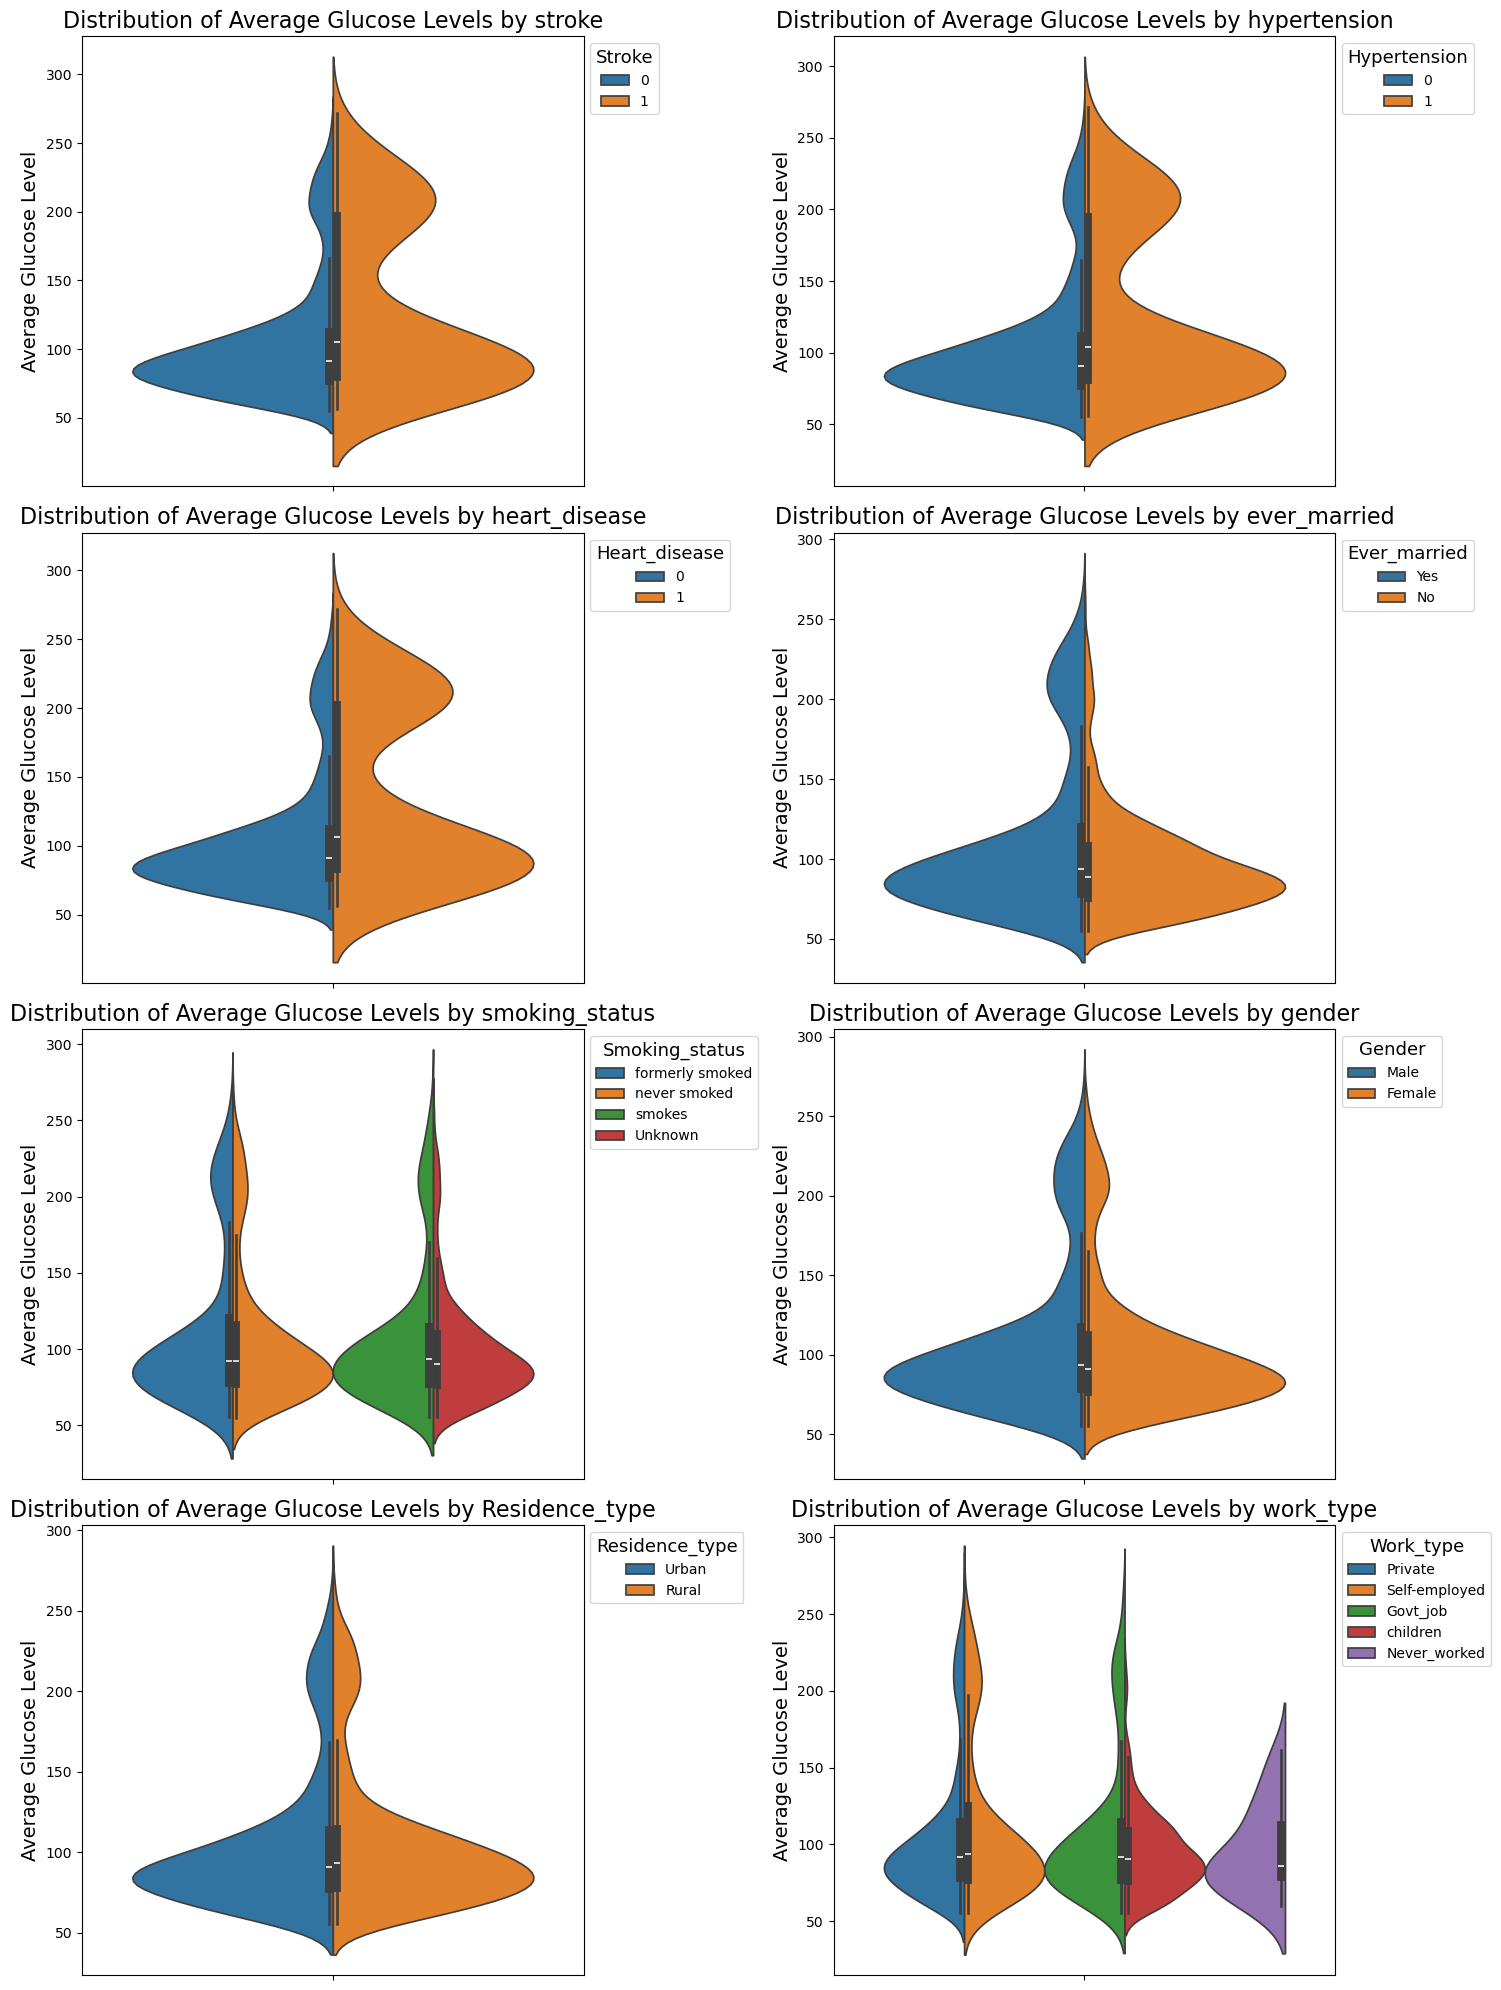

In [456]:
# Define the categorical variables for hue
categorical_vars = ["stroke", "hypertension", "heart_disease", "ever_married", "smoking_status", "gender", "Residence_type", "work_type"]

# Determine the number of rows and columns for the subplots grid
n_cols = 2
n_rows = (len(categorical_vars) + 1) // n_cols

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Create a violin plot for each hue variable
for i, var in enumerate(categorical_vars):
    sns.violinplot(data=df2, y='avg_glucose_level', hue=var, split=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Average Glucose Levels by {var}', fontsize=16)
    axes[i].set_ylabel('Average Glucose Level', fontsize=14)
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, title=var.capitalize(), title_fontsize='13', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add title and adjust layout
display(HTML(f"<h4>{'Blood Sugar Levels by categorical variables'}</h4>"))
plt.tight_layout()
plt.show()

##### Comment

We can see that subjects with a history or presence of heart-disease, hypertension, and stroke all have higher blood sugar levels than those without these factors present. Also, people that have been married also seem to have a tendency to higher blood sugar levels.

### Age

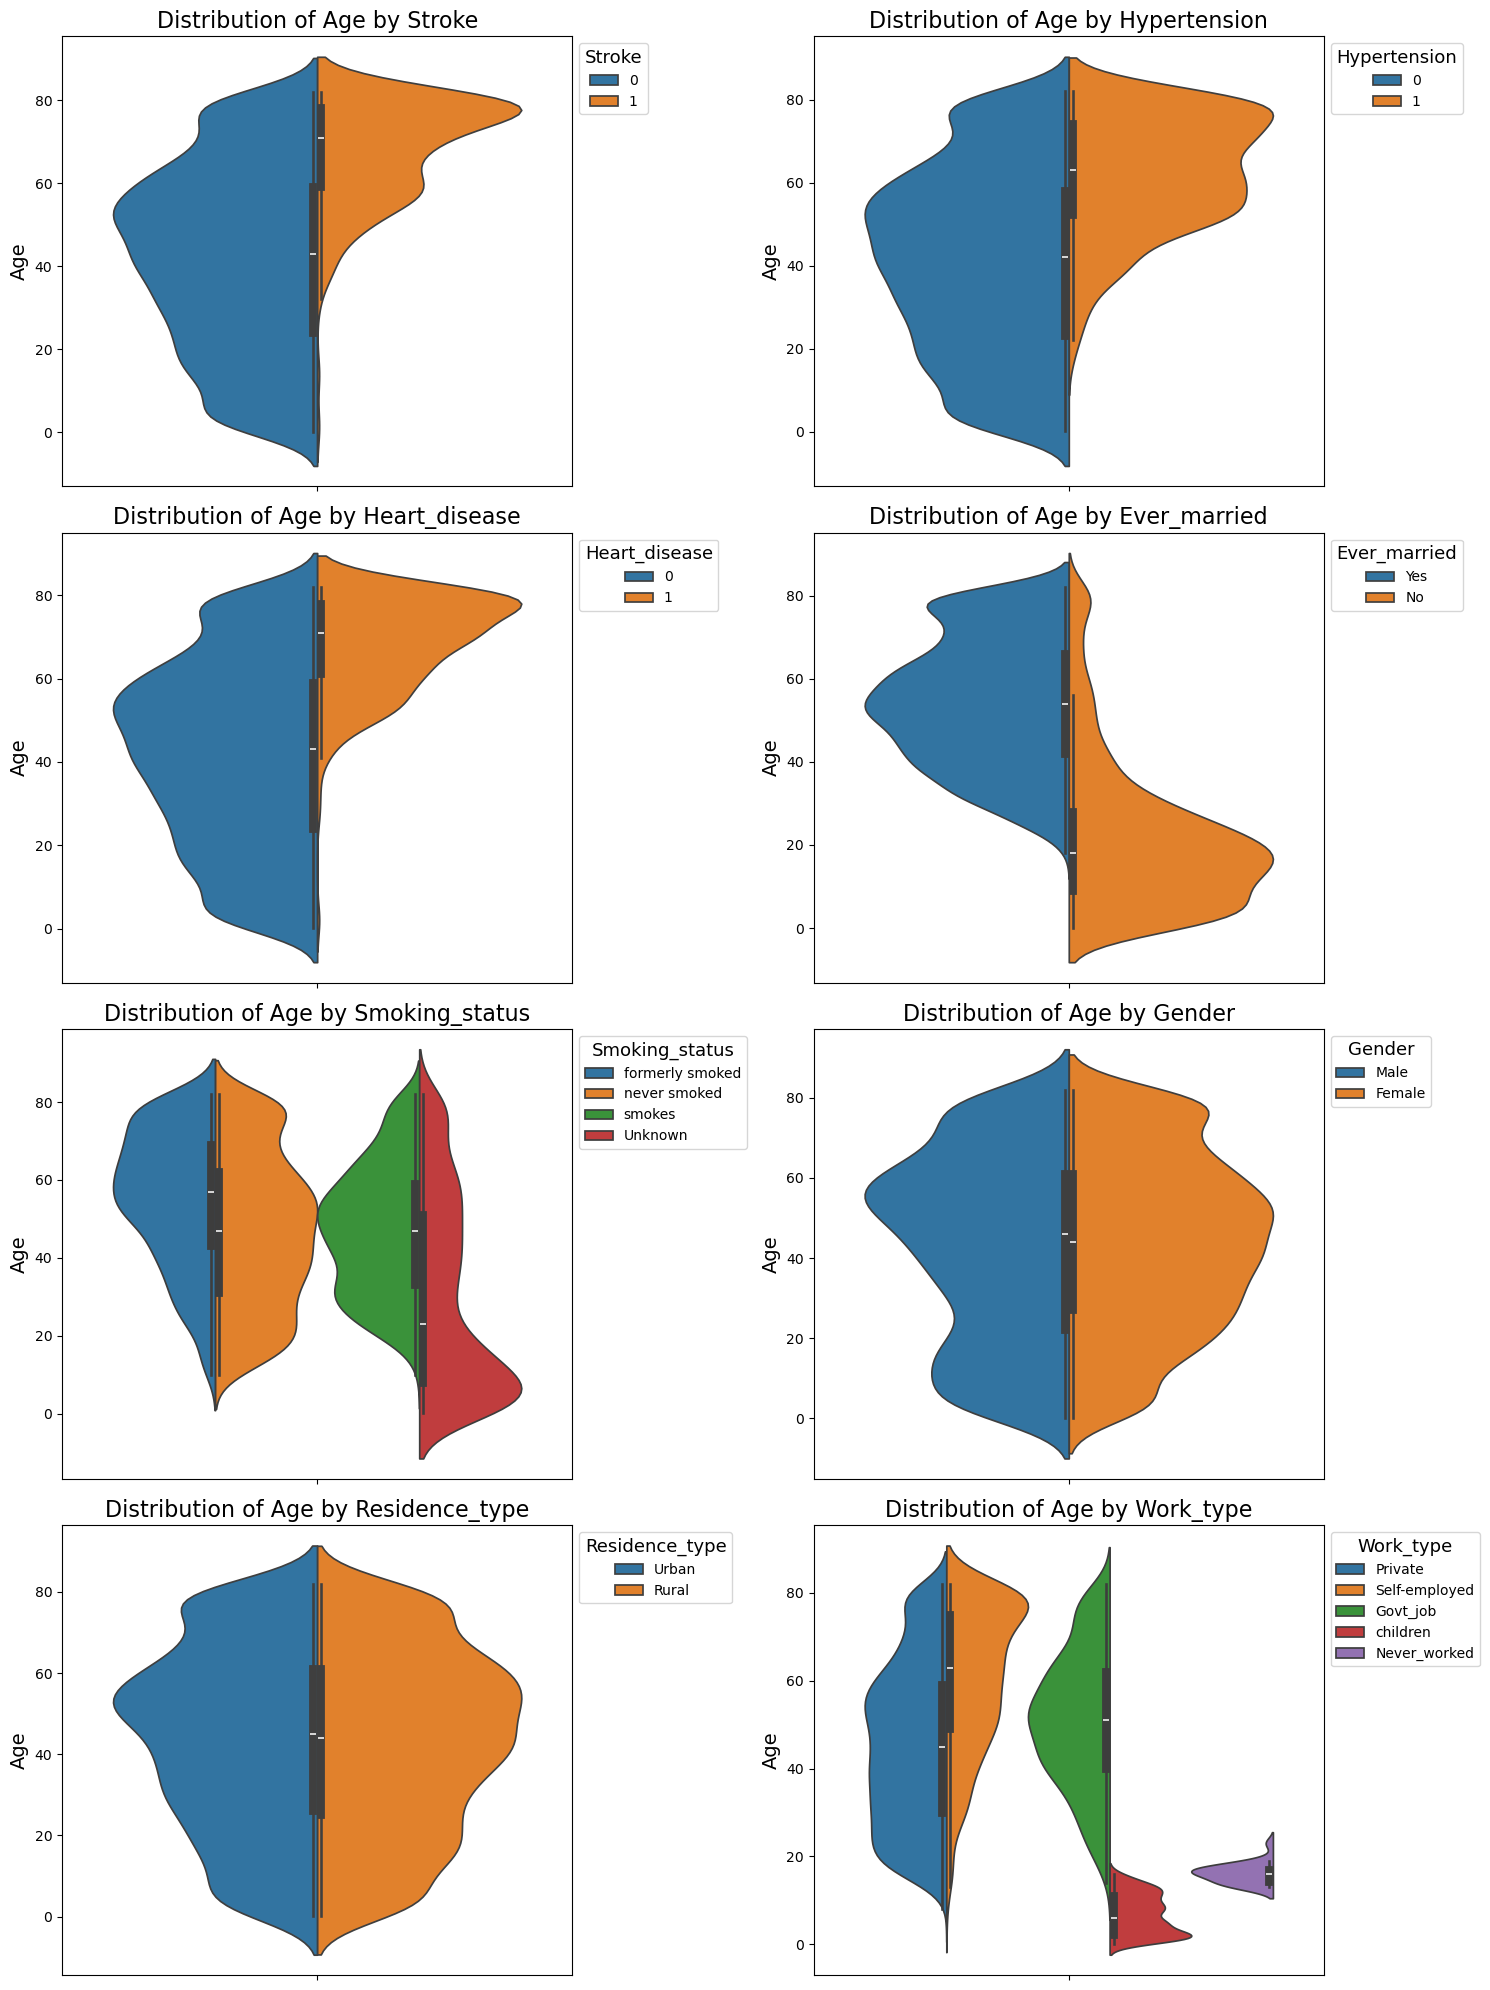

In [460]:
# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Create a violin plot for each hue variable
for i, var in enumerate(categorical_vars):
    sns.violinplot(data=df2, y='age', hue=var, split=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Age by {var.capitalize()}', fontsize=16)
    axes[i].set_ylabel('Age', fontsize=14)
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, title=var.capitalize(), title_fontsize='13', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add title and adjust layout
display(HTML(f"<h4>{'Age by categorical variables'}</h4>"))
plt.tight_layout()
plt.show()

##### Comment

We can see that there's a strong age discrepancy in age for the variables stroke, hypertension and heart disease with a bias towards older subjects if that factor is present. The difference in marital status is also significant, but due to the fact that the dataset included people under 18 years.

### BMI

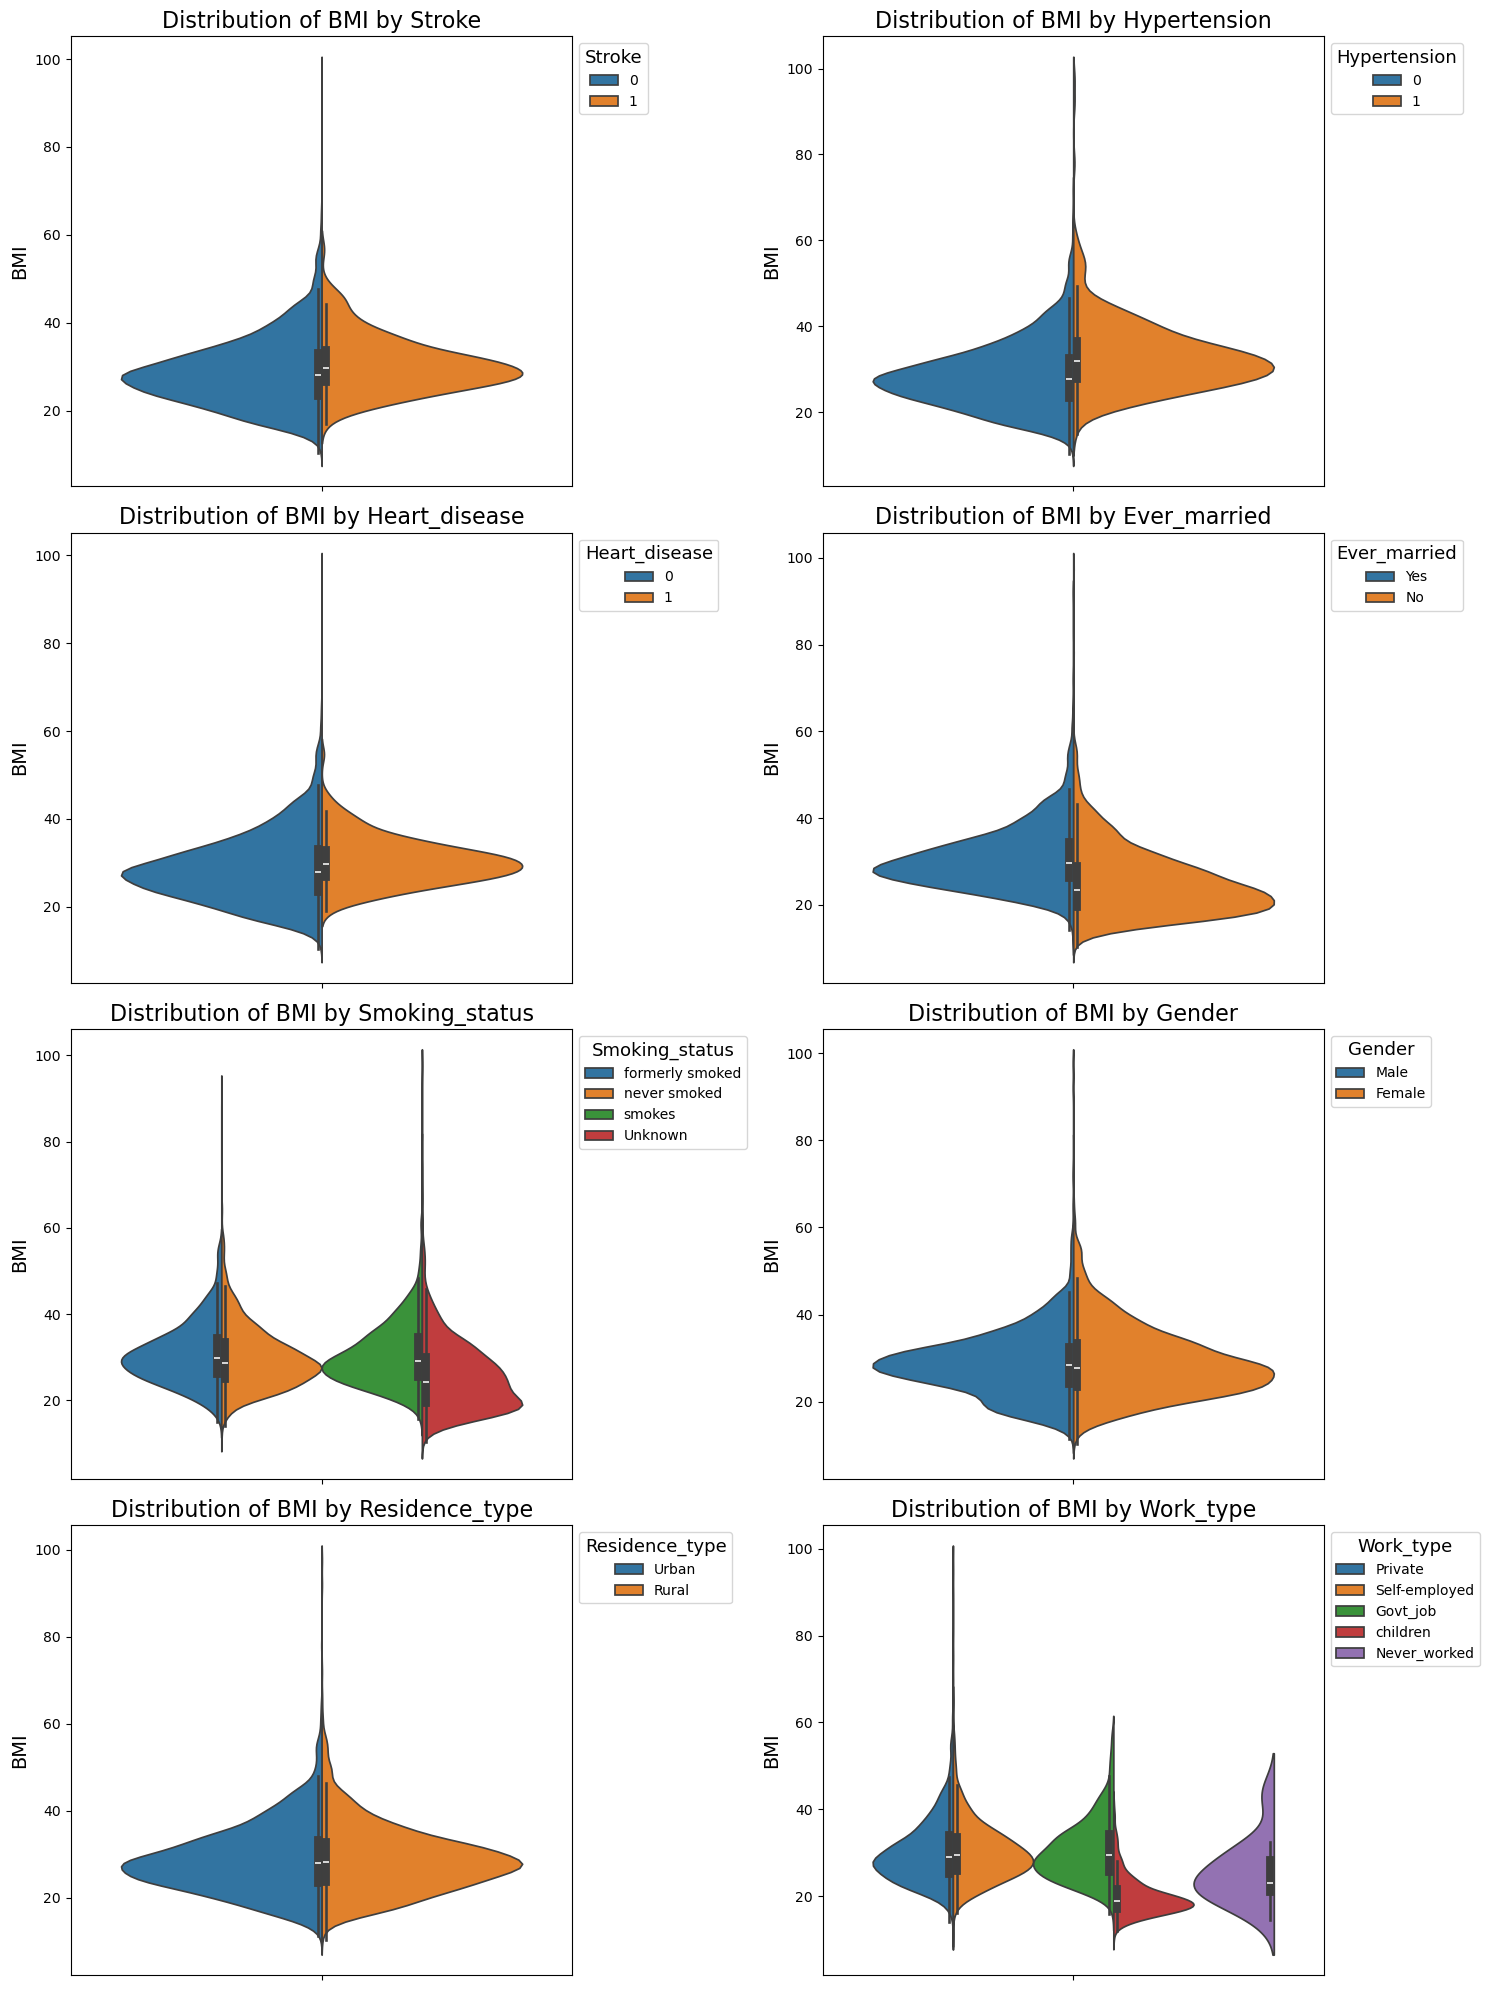

In [464]:
# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Create a violin plot for each hue variable
for i, var in enumerate(categorical_vars):
    sns.violinplot(data=df2, y='bmi', hue=var, split=True, ax=axes[i])
    axes[i].set_title(f'Distribution of BMI by {var.capitalize()}', fontsize=16)
    axes[i].set_ylabel('BMI', fontsize=14)
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, title=var.capitalize(), title_fontsize='13', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add title and adjust layout
display(HTML(f"<h4>{'BMI by categorical variables'}</h4>"))
plt.tight_layout()
plt.show()

##### Comment 

There's only a slight deviation in the distribution of BMI in regards to the existence of heart disease, hypertension and stroke - but only marginally.
The visually most significant difference in BMI is explained by marital status, with people who have been married having a ghigher BMI than those who never have been married.

### Correlation

We can see that in two out of the three metric variables, the variables hypertension and heart disease seem to play an important role for the presence of a stroke.
I now want to check, whether hypertension and heart disease are correlated or have covariance. Technically, they could since both are an indicator for vascular health. But are they correlated?

In [468]:
# Calculate the correlation matrix
corr_matrix = df_dummy.corr()

In [470]:
#Filter correlations above the threshold (0.2)
threshold = 0.2
high_corr = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1.0)]

#Extract the pairs of variables with high correlation
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

#Remove duplicates (each pair appears twice in the matrix)
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable1'] < high_corr_pairs['Variable2']]

print("\nPairs with Correlation Above 0.2:\n", high_corr_pairs)


Pairs with Correlation Above 0.2:
                          Variable1                       Variable2  \
0                              age                    hypertension   
1                              age                   heart_disease   
2                              age               avg_glucose_level   
3                              age                             bmi   
4                              age                          stroke   
5                              age                ever_married_Yes   
6                              age         work_type_Self-employed   
7                              age              work_type_children   
8                              age  smoking_status_formerly smoked   
13                             bmi                ever_married_Yes   
14                             bmi               work_type_Private   
15                             bmi              work_type_children   
19                ever_married_Yes              work_t

##### Comment

It seems hypertension and heart disease are - in this sample - only marginally correlated (0.108) which means we will keep both variables as predictors.
This is in line with current studies, as both - seperately - are considered predictors for stroke / factor into stroke risk (Arboix, 2015; Joundi et al., 2022).
There are also no other intercorrelations above 0.2 that I would find troublesome. However, there's only one correlation for our stroke variable over 0.2 which is age. This could lead to problems in the model later on since this could mean, that our variables have low informative value on the existence or emergence of a stroke.

## Splitting the data

In [474]:
#Setting my X and Y variable
X = df_dummy.drop('stroke', axis=1) # axis=1 for column-wise operation
y = df_dummy['stroke']

In [476]:
#Sanity Check
print(f'X_shape: {X.shape}')
print(f'y_shape: {y.shape}')

X_shape: (5109, 15)
y_shape: (5109,)


In [478]:
# StratifiedShuffleSplit Original
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform stratified sampling 
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [480]:
# Sanity Check!
print("Training set:")
print(X_train.shape)
print(y_train.shape)

print("Test set:")
print(X_test.shape)
print(y_test.shape)

Training set:
(4087, 15)
(4087,)
Test set:
(1022, 15)
(1022,)


# Clearing the Clot - Data Preprocessing

Now we know what we are dealing with, cleaned up some blemishes and split our data into train and test set!
Now that we've done this we also want to do some data preprocessing in order to deal with missing values and outliers.

## Outliers

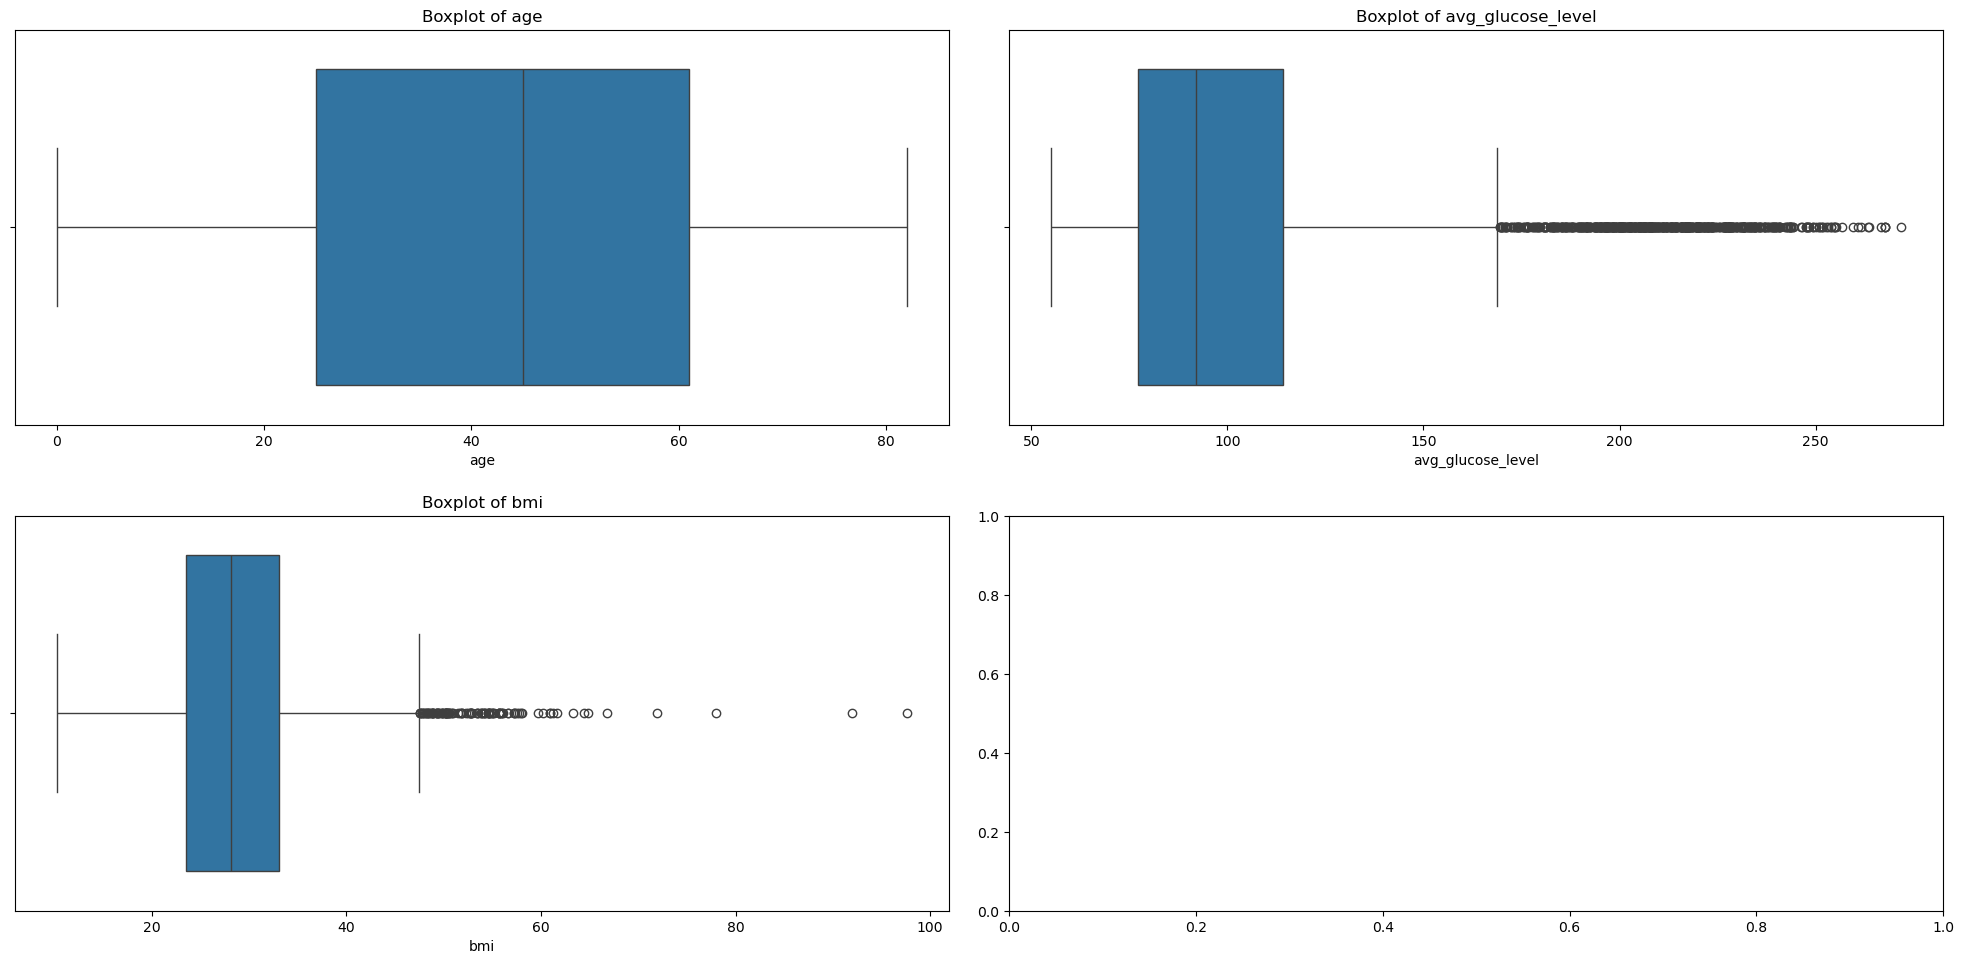

In [483]:
#Plotting boxplots to look for outliers in X_train
max_cols_per_row = 2
num_cols = ["age", "avg_glucose_level","bmi"]
num_rows = math.ceil(len(num_cols) / max_cols_per_row)

fig, axes = plt.subplots(num_rows, max_cols_per_row, figsize=(20, 10))
axes = axes.flatten()

# For all numerated columns make a sublpot and give a titel with the column name
for i, col in enumerate(num_cols):
    sns.boxplot(x=col, data=df_dummy, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    
display(HTML(f"<h4>{'Outliers'}</h4>"))
plt.tight_layout(pad=2.0)
plt.show()

##### Comment
We can see that for age, visually there seem to be no outliers present. However, the average glucose level (as already suspected) and the BMI seem to have significatn outliers. Let's take a look at them.

### Outliers BMI

#### Outliers X_train

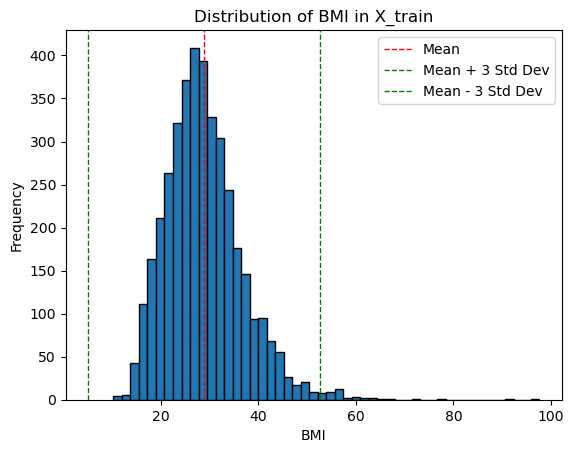

In [488]:
# Distribution of BMI values with Standard Derivation in X_train
plt.hist(X_train['bmi'], bins=50, edgecolor='k')
plt.axvline(X_train['bmi'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(X_train['bmi'].mean() + 3 * X_train['bmi'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean + 3 Std Dev')
plt.axvline(X_train['bmi'].mean() - 3 * X_train['bmi'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean - 3 Std Dev')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Distribution of BMI in X_train')
plt.legend()
plt.show()

In [489]:
# Calculate z-scores for each column in X_train
z_scores = (X_train['bmi'] - X_train['bmi'].mean()) / X_train['bmi'].std()

# Count the number of outliers
outliers_train = (z_scores.abs() > 3).sum()

# Print the results
print("Number of outliers in X_train based on z > 3:")
print(outliers_train)

Number of outliers in X_train based on z > 3:
44


In [88]:
# Retrieve the outliers
outliers_mask = z_scores.abs() > 3
outliers_table = X_train['bmi'][outliers_mask]

# Printing results
print("Outliers in the 'bmi' column:")
print(outliers_table)

Outliers in the 'bmi' column:
430     54.7
2128    97.6
4154    57.2
113     56.6
466     60.2
1559    66.8
3588    59.7
3931    54.3
928     78.0
4209    92.0
270     60.9
1322    54.8
2815    52.8
3909    53.8
3702    54.7
3688    52.9
3825    61.6
544     71.9
662     55.7
2071    54.0
1595    57.3
1532    52.8
4188    64.4
358     64.8
2764    63.3
1304    55.0
2081    56.1
1584    55.9
4225    55.9
1061    53.4
1077    55.2
4475    57.2
1660    56.0
672     55.7
2840    61.2
2555    55.7
4952    56.6
4351    57.9
3508    53.4
1898    57.7
1564    55.1
333     54.7
4407    55.7
2567    53.5
Name: bmi, dtype: float64


In [90]:
# Create a copy of X_train to X_train2
X_train2 = X_train.copy()

# Calculate z-scores for the 'bmi' column
z_scores = (X_train['bmi'] - X_train['bmi'].mean()) / X_train['bmi'].std()

# Define threshold for outliers
threshold = 3

# Create mask for outliers
outliers_mask = z_scores.abs() > threshold

# Replace outliers with NaNs in X_train2
X_train2.loc[outliers_mask, 'bmi'] = np.nan

missing_removed = X_train2["bmi"].isna().sum() - X_train["bmi"].isna().sum()

# Sanity Check!
print(f'There are {X_train["bmi"].isna().sum()} missing values in X_train (original)')
print(f'There are {X_train2["bmi"].isna().sum()} missing values in X_train2 (after replacing outliers)')
print(f'There have been {missing_removed} missing values removed')

There are 163 missing values in X_train (original)
There are 207 missing values in X_train2 (after replacing outliers)
There have been 44 missing values removed


#### Outliers X_test

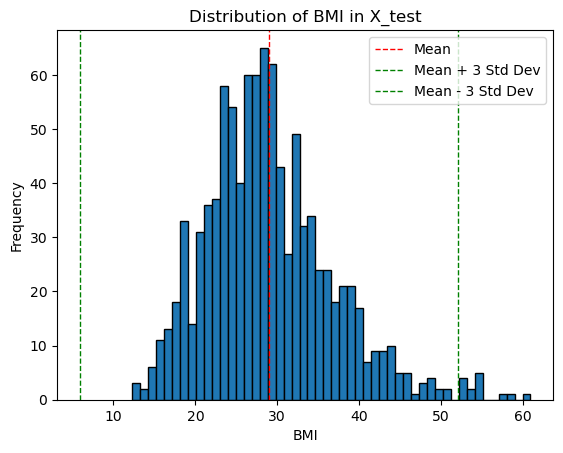

In [93]:
plt.hist(X_test['bmi'], bins=50, edgecolor='k')
plt.axvline(X_test['bmi'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(X_test['bmi'].mean() + 3 * X_test['bmi'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean + 3 Std Dev')
plt.axvline(X_test['bmi'].mean() - 3 * X_test['bmi'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean - 3 Std Dev')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Distribution of BMI in X_test')
plt.legend()
plt.show()

In [95]:
# Calculate z-scores for each column in X_train
z_scores_2 = (X_test['bmi'] - X_test['bmi'].mean()) / X_test['bmi'].std()

# Count the number of outliers
outliers_test_2 = (z_scores_2.abs() > 3).sum()

print("Number of outliers in X_test based on z > 3:")
print(outliers_test_2)

Number of outliers in X_test based on z > 3:
14


In [97]:
# Retrieve the outliers
outliers_mask_2 = z_scores_2.abs() > 3
outliers_table_2 = X_test['bmi'][outliers_mask_2]

print("Outliers in the 'bmi' column:")
print(outliers_table_2)

Outliers in the 'bmi' column:
637     54.6
715     57.5
3606    52.5
258     54.6
2136    53.9
2441    52.7
3243    52.7
3980    55.0
4838    60.9
2545    52.8
3060    58.1
2330    53.8
761     54.2
4906    54.1
Name: bmi, dtype: float64


In [499]:
# Create a copy of X_train to X_train2
X_test2 = X_test.copy()

# Calculate z-scores for the 'bmi' column
z_scores_test = (X_test['bmi'] - X_test['bmi'].mean()) / X_test['bmi'].std()

# Create mask for outliers
outliers_mask_test = z_scores_test.abs() > threshold

# Replace outliers with NaNs in X_train2
X_test2.loc[outliers_mask_test, 'bmi'] = np.nan

missing_removed2 = X_test2["bmi"].isna().sum() - X_test["bmi"].isna().sum()

# Sanity Check!
print(f'There are {X_test["bmi"].isna().sum()} missing values in X_test (original)')
print(f'There are {X_test2["bmi"].isna().sum()} missing values in X_test2 (after replacing outliers)')
print(f'There have been {missing_removed2} missing vales removed.')

There are 38 missing values in X_test (original)
There are 843 missing values in X_test2 (after replacing outliers)
There have been 805 missing vales removed.


#### Outlier in Average Glucose Levels

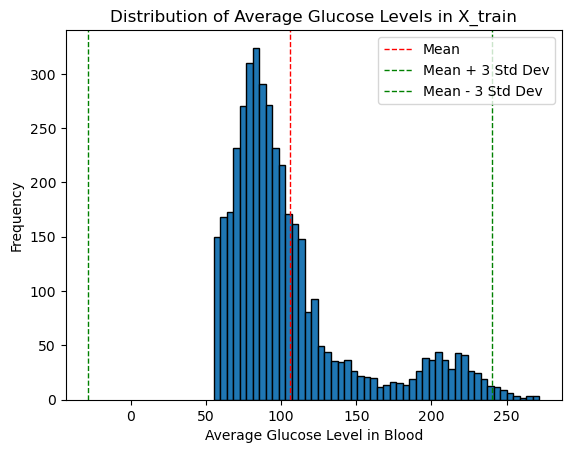

In [501]:
# Outliers in X train
plt.hist(X_train['avg_glucose_level'], bins=50, edgecolor='k')
plt.axvline(X_train['avg_glucose_level'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(X_train['avg_glucose_level'].mean() + 3 * X_train['avg_glucose_level'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean + 3 Std Dev')
plt.axvline(X_train['avg_glucose_level'].mean() - 3 * X_train['avg_glucose_level'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean - 3 Std Dev')
plt.xlabel('Average Glucose Level in Blood')
plt.ylabel('Frequency')
plt.title('Distribution of Average Glucose Levels in X_train')
plt.legend()
plt.show()

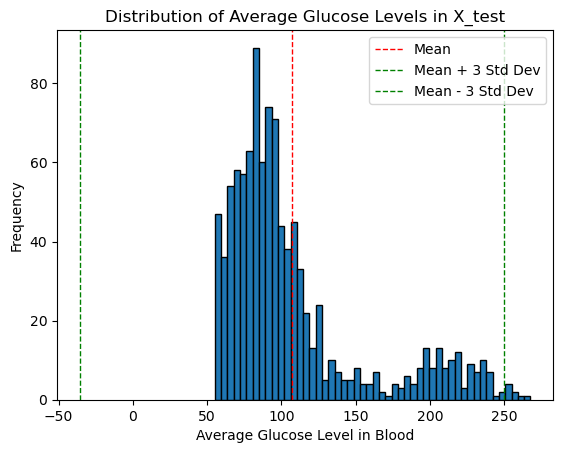

In [503]:
# Outlier ins X test
plt.hist(X_test['avg_glucose_level'], bins=50, edgecolor='k')
plt.axvline(X_test['avg_glucose_level'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(X_test['avg_glucose_level'].mean() + 3 * X_test['avg_glucose_level'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean + 3 Std Dev')
plt.axvline(X_test['avg_glucose_level'].mean() - 3 * X_test['avg_glucose_level'].std(), color='g', linestyle='dashed', linewidth=1, label='Mean - 3 Std Dev')
plt.xlabel('Average Glucose Level in Blood')
plt.ylabel('Frequency')
plt.title('Distribution of Average Glucose Levels in X_test')
plt.legend()
plt.show()

##### Comment

I would like to keep the outliers in average glucose level, since there's a significant amount of them.
If I would remove them, I would loose information on elevated blood sugar levels (which, as established, a blood sugar level of over 170 mg/dL is). I will keep this in mind for my model selection. However, we can do a BoxCox transformation to try and normalize the distribution.

In [506]:
feature = X_train2['avg_glucose_level']

# Ensure the feature is strictly positive
if (feature <= 0).any():
    feature = feature + 1 - feature.min()

# Apply Box-Cox transformation
boxcox_glucose_train, fitted_lambda = stats.boxcox(feature)

# Replace in dataframe
X_train2['avg_glucose_level'] = boxcox_glucose_train

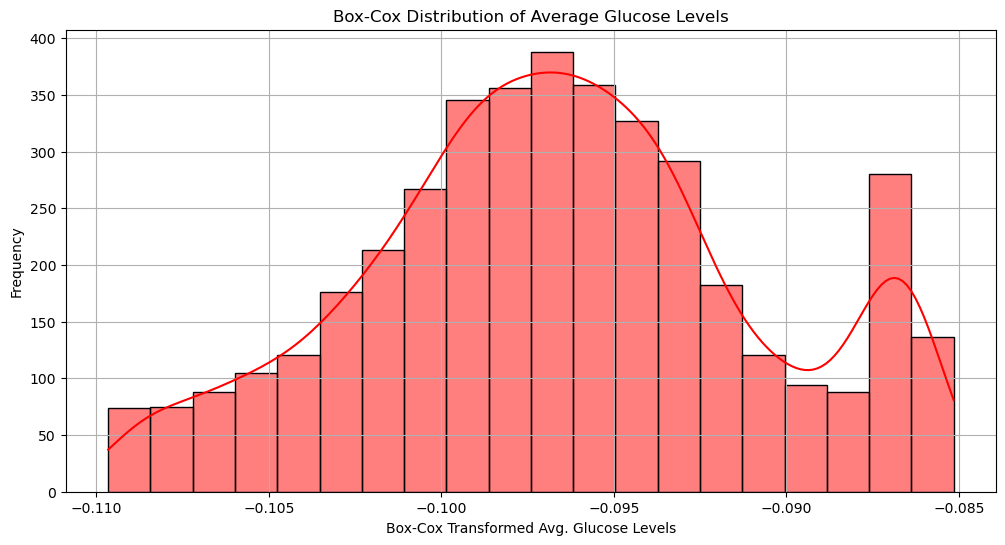

In [508]:
# Plot Box-Cox transformed data
plt.figure(figsize=(12, 6))
sns.histplot(boxcox_glucose_train, bins=20, color='r', kde=True)
plt.title('Box-Cox Distribution of Average Glucose Levels')
plt.xlabel('Box-Cox Transformed Avg. Glucose Levels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [510]:
# Sanity Check!
print(X_train2['avg_glucose_level'])

845    -0.102919
3745   -0.098392
4184   -0.092501
3410   -0.093861
284    -0.098854
          ...   
1434   -0.096492
461    -0.093219
1052   -0.099847
1757   -0.101236
5053   -0.109278
Name: avg_glucose_level, Length: 4087, dtype: float64


In [512]:
feature = X_test2['avg_glucose_level']

# Ensure the feature is strictly positive
if (feature <= 0).any():
    feature = feature + 1 - feature.min()

# Apply Box-Cox transformation
boxcox_glucose_test, fitted_lambda = stats.boxcox(feature)

# Replace in dataframe
X_test2['avg_glucose_level'] = boxcox_glucose_test

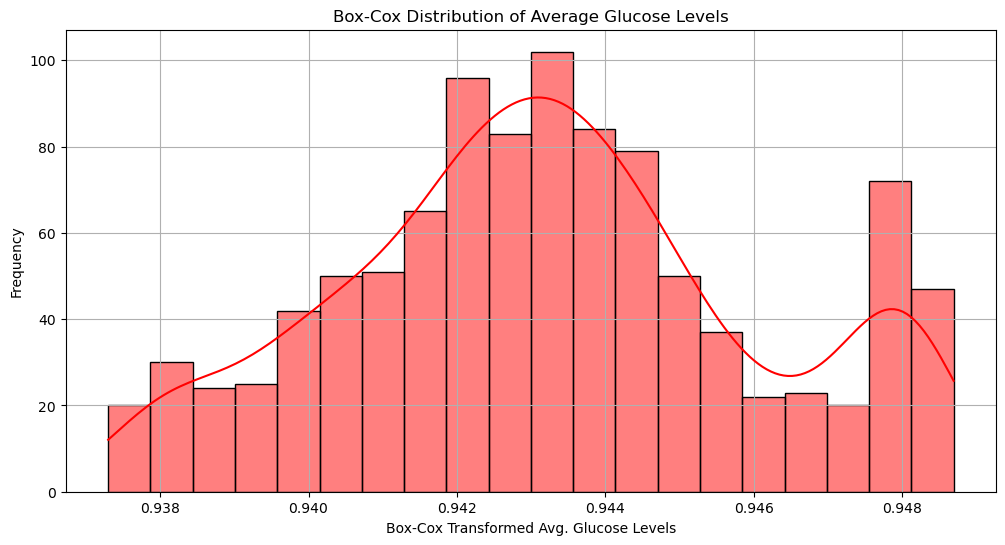

In [514]:
# Plot Box-Cox transformed data
plt.figure(figsize=(12, 6))
sns.histplot(boxcox_glucose_test, bins=20, color='r', kde=True)
plt.title('Box-Cox Distribution of Average Glucose Levels')
plt.xlabel('Box-Cox Transformed Avg. Glucose Levels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [117]:
# Sanity Check!
print(X_test2['avg_glucose_level'])

3667    0.942293
2217    0.943275
374     0.939422
2392    0.940294
299     0.943365
          ...   
2083    0.944375
668     0.945052
4381    0.943032
2514    0.941774
2939    0.938134
Name: avg_glucose_level, Length: 1022, dtype: float64


## Missing Values

While we dealt with our outliers, we could see that we not only already had multiple missing values, but we also created some new ones.
Let's deal with them via imputing.

### Imputing X_train

In [121]:
kds_train = mf.ImputationKernel(X_train2, save_all_iterations=True, random_state=42)

# Run the MICE algorithm for 5 iterations
kds_train.mice(10)

# Return the completed dataset.
X_train_imputed = kds_train.complete_data()

#Sanity Check
print(f'There are {X_train_imputed.isna().values.sum()} missing values in X_train')

There are 0 missing values in X_train


### Imputing X_test

In [123]:
kds_test = mf.ImputationKernel(X_test2, save_all_iterations=True, random_state=42)

# Run the MICE algorithm for 5 iterations
kds_test.mice(10)

# Return the completed dataset.
X_test_imputed = kds_test.complete_data()

#Sanity Check
print(f'There are {X_test_imputed.isna().values.sum()} missing values in X_test')

There are 0 missing values in X_test


In [125]:
# Sanity Check!
print("Training set:")
print(X_train_imputed.shape)
print(y_train.shape)

print("Test set:")
print(X_test_imputed.shape)
print(y_test.shape)

Training set:
(4087, 15)
(4087,)
Test set:
(1022, 15)
(1022,)


## Scaling Data

For our models, we need to scale our data, since BMI, Age and Blood Glucose Level all have different ranges and units.


In [129]:
# Scaling our data with the robust scaler since we have outliers in average glucose level
scaler = RobustScaler()

# Scaling Input Features
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# It's a stroke story -  Model Selection

Halfway through! I hope you didn't have a stroke reading all this up to here ;)

Now, we want to get into training a model to check, what will help predcit a stroke in patients (with the given informations we have at hand).
The only constraint through my assignment is that I need to run three machine learning models from different families.

With regards to my dataset, in which my target variable is binary, I decided on the following three algorithms:

##### Logistic Regression

I will first run a logistic regression as a "baseline" model, since it is straightforward, simple to implement and easy to interpret. It also works well with binary classifications and can handle imbalanced data sets with the class weight option.

##### Random Forst

Next up, I will run a decision tree using Random Forests since this model can handle both continuous and categorical variables well and is good for imbalanced datasets. Again, I can use class weights here to ensure a better fitting model with regards to my data set.
Here I can capture non-linear relationsips and interactions and this algorithm is also robust against any outliers remaining in my dataset.

##### Support Vector Machines

As my third model, I will use a Support Vector Machine (SVM) algorithm since I have a standard, binary classifications task at hand. In this model I also can work with class weights to adress imbalances. As a powerful and more complex model, it is a good "final" model to compare. Here, we aim to create a clear decision boundary for our stroke variable, hoping to maximize the distance between our stroke and non-stroke group. I also have some kernel flexibility if I wanted to adapt my model accordingly.

By chossing these models, I don't necessarily have to deal with imbalances beforehand - but could do so should my models not perform well.

# Is this a stroke? - Model Training and Evaluation

## Logistic Regression

### Model Building

In [135]:
# Initializing the Logistic Regression
log_reg = LogisticRegression(random_state = 0, class_weight='balanced').fit(X_train_scaled, y_train)
log_reg.predict(X_train_scaled)
y_pred_log1 = log_reg.predict(X_test_scaled)

### Model Evaluation

In [138]:
# Accuracy on training set
log_reg.score(X_train_scaled, y_train)

0.7406410570100318

In [140]:
# Accuracy on test set
log_reg.score(X_test_scaled, y_test)

0.6663405088062623

In [516]:
# Confusion Matrix
cm_reg = confusion_matrix(y_test, y_pred_log1)
print("Confusion Matrix Logistic Regression:\n", cm_reg)

Confusion Matrix Logistic Regression:
 [[639 333]
 [  8  42]]


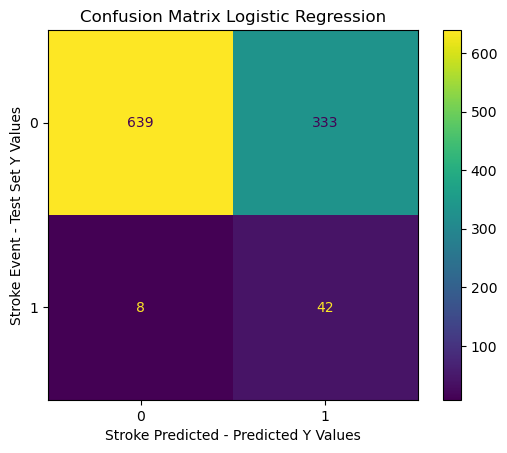

In [144]:
# Visualizing the Confusion Matrix
cm_dis_log1 = ConfusionMatrixDisplay(cm_reg)
cm_dis_log1.plot()
plt.title('Confusion Matrix Logistic Regression')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [532]:
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_log1))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.66      0.79       972
           1       0.11      0.84      0.20        50

    accuracy                           0.67      1022
   macro avg       0.55      0.75      0.49      1022
weighted avg       0.94      0.67      0.76      1022



In [148]:
# Prediction probabilities
y_prob_log1 = log_reg.predict_proba(X_test_scaled)
print(y_prob_log1)

[[0.84994715 0.15005285]
 [0.96241286 0.03758714]
 [0.52023653 0.47976347]
 ...
 [0.74381249 0.25618751]
 [0.95874095 0.04125905]
 [0.7408468  0.2591532 ]]


In [518]:
# Calculate ROC curve
fpr_log1, tpr_log1, thresholds_log1 = roc_curve(y_test, y_prob_log1[:, 1])
# Calculate AUC
roc_auc_log1 = auc(fpr_log1, tpr_log1)
print("The AUC for Logisitic Regression is:", roc_auc_log1)

The AUC for Logisitic Regression is: 0.8428189300411523


In [520]:
# Brier Score for good measure
brier_loss_log1 = brier_score_loss(y_test, y_prob_log1[:, 1])
print("The Brier Loss for Logistic Regression is:", brier_loss_log1)

The Brier Loss for Logistic Regression is: 0.21936711731703679


### Model Adaptation

#### Oversampling

In [156]:
# Oversampling training set
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)

X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train_imputed.columns)

In [158]:
# Initializing the Logistic Regression
log_reg_OS = LogisticRegression(random_state = 0, class_weight = 'balanced').fit(X_train_resampled, y_train_resampled)
y_pred_log2 = log_reg_OS.predict(X_test_scaled)

In [160]:
# Accuracy on training set
log_reg_OS.score(X_train_resampled, y_train_resampled)

0.7856224279835391

In [534]:
# Confusion Matrix
cm_reg_OS = confusion_matrix(y_test, y_pred_log2)
print("Confusion Matrix for Logistic Regression with Oversampling:\n", cm_reg_OS)

Confusion Matrix for Logistic Regression with Oversampling:
 [[655 317]
 [  8  42]]


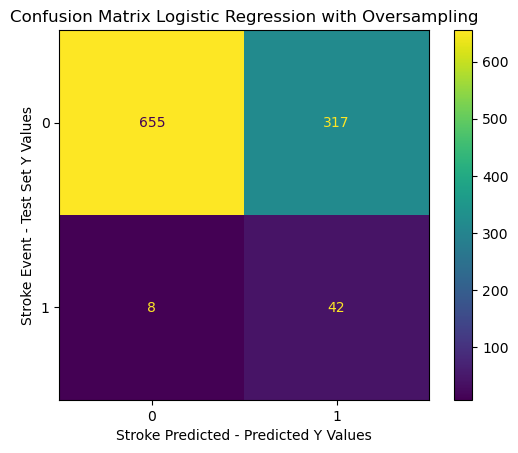

In [536]:
# Visualizing the Confusion Matrix
cm_display_OS = ConfusionMatrixDisplay(cm_reg_OS)
cm_display_OS.plot()
plt.title('Confusion Matrix Logistic Regression with Oversampling')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [530]:
print("Classification Report for LR with Oversamling:\n", classification_report(y_test, y_pred_log2))

Classification Report for LR with Oversamling:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.12      0.84      0.21        50

    accuracy                           0.68      1022
   macro avg       0.55      0.76      0.50      1022
weighted avg       0.95      0.68      0.77      1022



In [168]:
# Prediction probabilities
y_prob_log2 = log_reg_OS.predict_proba(X_test_scaled)
print(y_prob_log2)

[[0.86478652 0.13521348]
 [0.96173241 0.03826759]
 [0.49764692 0.50235308]
 ...
 [0.78073185 0.21926815]
 [0.96488344 0.03511656]
 [0.74529917 0.25470083]]


In [538]:
# Calculate ROC curve
fpr_log2, tpr_log2, thresholds_log2 = roc_curve(y_test, y_prob_log2[:, 1])
# Calculate AUC
roc_auc_log2 = auc(fpr_log2, tpr_log2)
print("The AUC for Logistic Regression with Oversampling is:", roc_auc_log2)

The AUC for Logistic Regression with Oversampling is: 0.8422427983539095


In [540]:
# Brier Score for good measure
brier_loss_log2 = brier_score_loss(y_test, y_prob_log2[:, 1])
print("The Brier Loss for Logistic Regression with Oversampling is:", brier_loss_log2)

The Brier Loss for Logistic Regression with Oversampling is: 0.2088197983053759


#### Feature Selection

In [546]:
stratified_kfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

rfecv = RFECV(log_reg_OS, min_features_to_select=1, cv=stratified_kfold, scoring='f1')
rfecv.fit(X_train_scaled, y_train)

optimal_num_features2 = rfecv.n_features_
print("Optimal number of features for Logistic Regression with Feature Selection: ", optimal_num_features2)

Optimal number of features for Logistic Regression with Feature Selection:  11


In [547]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

rfe = RFE(log_reg_OS, n_features_to_select=optimal_num_features2)
rfe = rfe.fit(X_train_scaled, y_train)

# Get the boolean mask of selected features
selected_features_mask = rfe.support_

# Get the names of the top features
selected_feature_names = X_train_scaled_df.columns[selected_features_mask]

# Print the top features
print("Selected Features for Logistic Regression with Feature Selection:", selected_feature_names)

Selected Features for Logistic Regression with Feature Selection: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'ever_married_Yes', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


In [548]:
X_train_top_features = X_train_scaled_df.loc[:, selected_feature_names]

# Subset test data with the same selected features
X_test_top_features = X_test_scaled_df.loc[:, selected_feature_names]

# Sanity Check
print("Shape of X_train with selected features:", X_train_top_features.shape)

Shape of X_train with selected features: (4087, 11)


In [552]:
# Confusion Matrix
cm_reg_features = confusion_matrix(y_test, y_pred_log3)
print("Confusion Matrix for Logistic Regression with Feature Selection :\n", cm_reg_features)

Confusion Matrix for Logistic Regression with Feature Selection :
 [[639 333]
 [  8  42]]


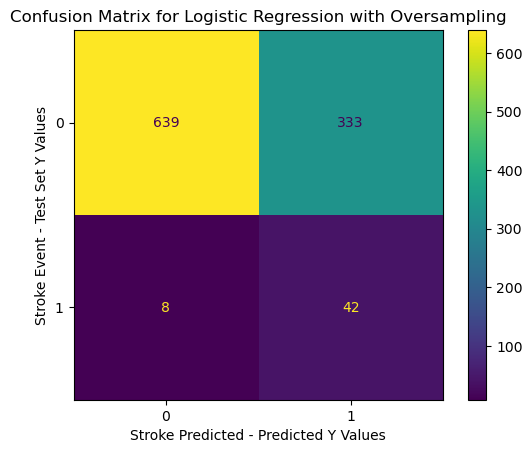

In [554]:
# Visualizing the Confusion Matrix
cm_dis_log3= ConfusionMatrixDisplay(cm_reg_features)
cm_dis_log3.plot()
plt.title('Confusion Matrix for Logistic Regression with Oversampling')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [556]:
# Train the model
log_reg_features = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train_top_features, y_train)

# Predict on test data
y_pred_log3 = log_reg_features.predict(X_test_top_features)

print("Classification Report for Logistic Regression with Feature Selection:\n", classification_report(y_test, y_pred_log3))

Classification Report for Logistic Regression with Feature Selection:
               precision    recall  f1-score   support

           0       0.99      0.66      0.79       972
           1       0.11      0.84      0.20        50

    accuracy                           0.67      1022
   macro avg       0.55      0.75      0.49      1022
weighted avg       0.94      0.67      0.76      1022



In [187]:
# Prediction probabilities
y_prob_log3 = log_reg_OS.predict_proba(X_test_scaled)
print(y_prob_log3)

[[0.86478652 0.13521348]
 [0.96173241 0.03826759]
 [0.49764692 0.50235308]
 ...
 [0.78073185 0.21926815]
 [0.96488344 0.03511656]
 [0.74529917 0.25470083]]


In [189]:
# Calculate ROC curve
fpr_log3, tpr_log3, thresholds_log3e = roc_curve(y_test, y_prob_log3[:, 1])
# Calculate AUC
roc_auc_log3 = auc(fpr_log3, tpr_log3)
print("The AUC of the Feature Selection Model is:", roc_auc_log3)

The AUC of the Feature Selection Model is: 0.8422427983539095


In [191]:
# Brier Score for good measure
brier_loss_log3 = brier_score_loss(y_test, y_prob_log3[:, 1])
print("The Brier Loss for the Feature Selection Model is:", brier_loss_log3)

The Brier Loss for the Feature Selection Model is: 0.2088197983053759


#### Hyperparameters

In [194]:
# Define the parameter grid
param_grid_log = {
    'C': [0.1, 1, 3, 5, 10],
    'penalty': ['l1', 'l2','elasticnet'],
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky', 'sag', 'saga'],
}

# Initialize GridSearchCV
grid_search_log = GridSearchCV(log_reg, param_grid_log, cv=stratified_kfold, scoring='f1', n_jobs=-1)

# Fit GridSearchCV
grid_search_log.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search_log.best_params_)
print("Best Score:", grid_search_log.best_score_)

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.23040396369748556


In [560]:
# Predict probabilities
y_prob_log4 = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_log4)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]

# Make predictions using the best threshold
y_pred_log4 = (y_prob_log4 >= best_threshold).astype(int)

cm_log_best_threshold = confusion_matrix(y_test, y_pred_log4)
print("Confusion Matrix with Hyperparemeter Tuning:\n", cm_log_best_threshold)

Confusion Matrix with Hyperparemeter Tuning:
 [[911  61]
 [ 26  24]]


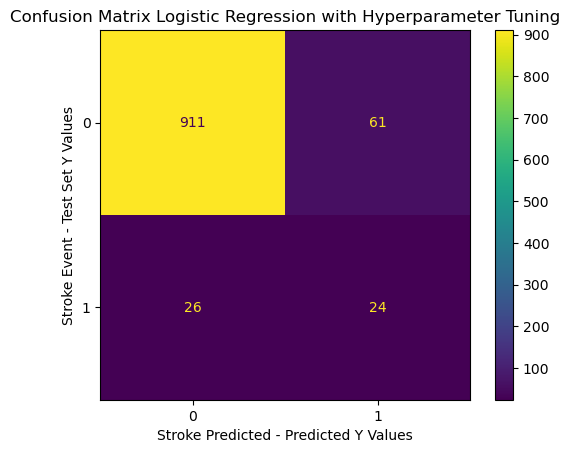

In [562]:
# Visualizing the Confusion Matrix
cm_dis_log4= ConfusionMatrixDisplay(cm_log_best_threshold)
cm_dis_log4.plot()
plt.title('Confusion Matrix Logistic Regression with Hyperparameter Tuning')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [564]:
# Print classification report and confusion matrix
print("Classification Report with Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_log4))

Classification Report with Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       972
           1       0.28      0.48      0.36        50

    accuracy                           0.91      1022
   macro avg       0.63      0.71      0.65      1022
weighted avg       0.94      0.91      0.93      1022



In [568]:
# Compute ROC Curve
fpr_log4, tpr_log4, thresholds_log4 = roc_curve(y_test, y_prob_log4)

# Calculate AUC
roc_auc_log4 = auc(fpr_log4, tpr_log4)
print("The AUC for the Logistic Regression with Hyperparemeter Tuning is:", roc_auc_log4)

The AUC for the Logistic Regression with Hyperparemeter Tuning is: 0.8428189300411523


In [570]:
# Brier Score for good measure
brier_loss_log4 = brier_score_loss(y_test, y_prob_log4)
print("The Brier Loss for the Logistic Regression with Hyperparemeter Tuning is:", brier_loss_log4)

The Brier Loss for the Logistic Regression with Hyperparemeter Tuning is: 0.21936711731703679


### Model Comparison

In [572]:
auc_log = {
    'Logistic Regression Model': roc_auc_log1,
    'Logistic Regression Model with Oversampling': roc_auc_log2,
    'Logistic Regression Model with RFE': roc_auc_log3,
    'Logistic Regression Model with Hyperparameter Tuning': roc_auc_log4
}

# Create a DataFrame
df_auc_log = pd.DataFrame(list(auc_log.items()), columns=['Model', 'AUC'])

# Display the DataFrame
display(HTML(f"<h4>{'Area Under Curve for Logistic Regression Models'}</h4>"))
df_auc_log.head()

,Model,AUC
0,Logistic Regression Model,0.842819
1,Logistic Regression Model with Oversampling,0.842243
2,Logistic Regression Model with RFE,0.842243
3,Logistic Regression Model with Hyperparameter ...,0.842819


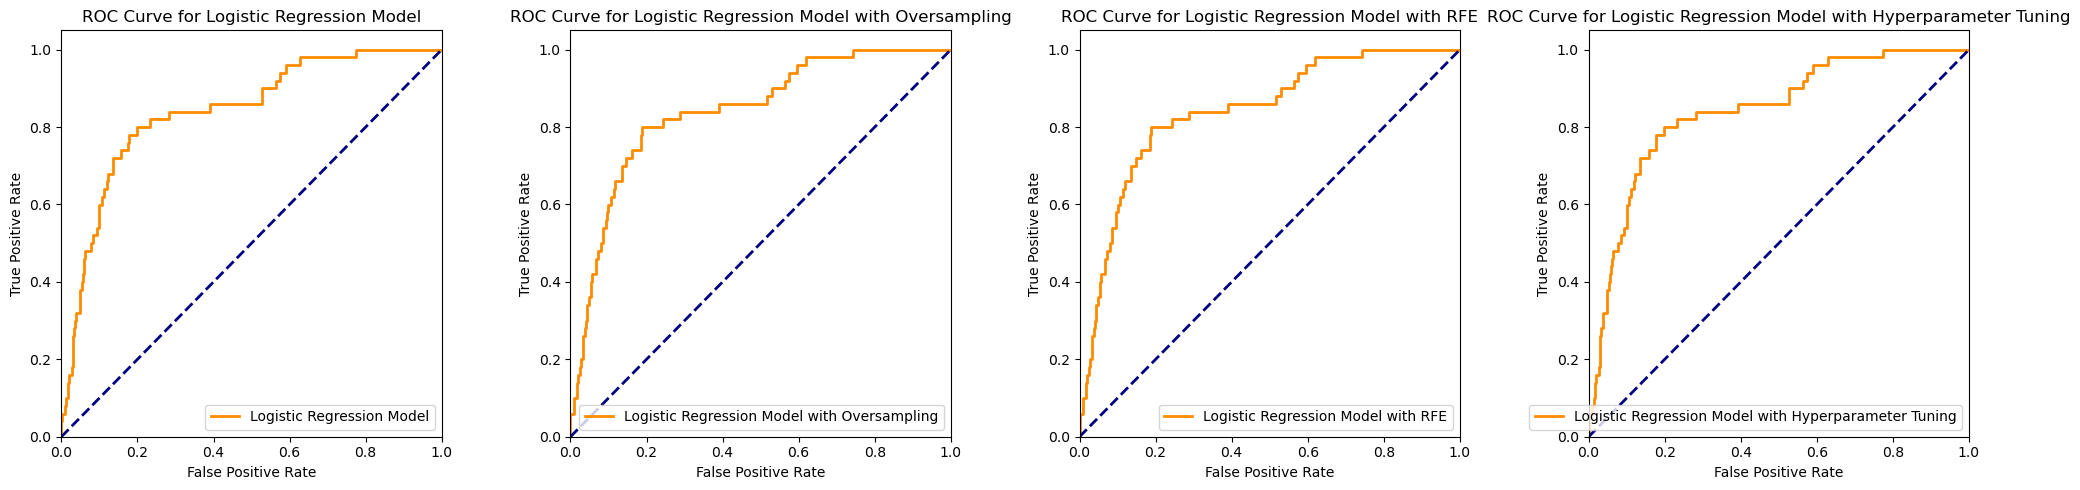

In [574]:
# Example data for multiple ROC curves
roc_curves_log = [
    {'fpr': fpr_log1, 'tpr': tpr_log1, 'label': 'Logistic Regression Model'},
    {'fpr': fpr_log2, 'tpr': tpr_log2, 'label': 'Logistic Regression Model with Oversampling'},
    {'fpr': fpr_log3, 'tpr': tpr_log3, 'label': 'Logistic Regression Model with RFE'},
    {'fpr': fpr_log4, 'tpr': tpr_log4, 'label': 'Logistic Regression Model with Hyperparameter Tuning'}
]

# Number of plots
num_plots_log = len(roc_curves_log)

# Create subplots (adjust rows and columns as needed)
fig, axes = plt.subplots(1, num_plots_log, figsize=(20, 5))

# Plot each ROC curve
for i, roc in enumerate(roc_curves_log):
    ax = axes[i]  # Select the appropriate subplot
    ax.plot(roc['fpr'], roc['tpr'], color='darkorange', lw=2, label=roc['label'])
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {roc["label"]}')
    ax.legend(loc='lower right')

# Add title and adjust alyout
display(HTML(f"<h4>{'ROC Curves for Logistic Regression Models'}</h4>"))
plt.tight_layout()
plt.show()

In [576]:
brier_scores_log = {
    'Logistic Regression Model': brier_loss_log1,
    'Logistic Regression Model with Oversampling': brier_loss_log2,
    'Logistic Regression Model with RFE': brier_loss_log3,
    'Logistic Regression Model with Hyperparameter Tuning': brier_loss_log4
}

# Create a DataFrame
df_brier_scores_log = pd.DataFrame(list(brier_scores_log.items()), columns=['Model', 'Brier Score'])

# Display the DataFrame
display(HTML(f"<h4>{'Brier Loss Scores'}</h4>"))
df_brier_scores_log.head()

,Model,Brier Score
0,Logistic Regression Model,0.219367
1,Logistic Regression Model with Oversampling,0.208820
2,Logistic Regression Model with RFE,0.208820
3,Logistic Regression Model with Hyperparameter ...,0.219367


In [578]:
reports_log = {
    'Model': ['Logistic Regression', 'Logistic Regression with Oversampling', 
              'Logistic Regression with Feature Selection', 
              'Logistic Regression with Hyperparameter Tuning'],
  'Precision (Majority)': [
        classification_report(y_test, y_pred_log1, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_log2, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_log3, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_log4, output_dict=True)['0']['precision']
    ],
     'Precision (Minority)': [
        classification_report(y_test, y_pred_log1, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_log2, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_log3, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_log4, output_dict=True)['1']['precision']
    ],
    'Recall (Majority)': [
        classification_report(y_test, y_pred_log1, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_log2, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_log3, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_log4, output_dict=True)['0']['recall']
    ],
    'Recall (Minority)': [
        classification_report(y_test, y_pred_log1, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_log2, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_log3, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_log4, output_dict=True)['1']['recall']
    ],
    'F1-Score (Majority)': [
        classification_report(y_test, y_pred_log1, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_log2, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_log3, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_log4, output_dict=True)['0']['f1-score']
    ],
    'F1-Score (Minority)': [
        classification_report(y_test, y_pred_log1, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_log2, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_log3, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_log4, output_dict=True)['1']['f1-score']
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log1),
        accuracy_score(y_test, y_pred_log2),
        accuracy_score(y_test, y_pred_log3),
        accuracy_score(y_test, y_pred_log4)
    ] }

df_report_log = pd.DataFrame(reports_log)

# Display the DataFrame as an HTML table
display(HTML(f"<h4>Classification Reports for Logistic Regression Model Adaptation</h4>"))
display(df_report_log)

,Model,Precision (Majority),Precision (Minority),Recall (Majority),Recall (Minority),F1-Score (Majority),F1-Score (Minority),Accuracy
0,Logistic Regression,0.987635,0.112000,0.657407,0.84,0.789376,0.197647,0.666341
1,Logistic Regression with Oversampling,0.987934,0.116992,0.673868,0.84,0.801223,0.205379,0.681996
2,Logistic Regression with Feature Selection,0.987635,0.112000,0.657407,0.84,0.789376,0.197647,0.666341
3,Logistic Regression with Hyperparameter Tuning,0.972252,0.282353,0.937243,0.48,0.954426,0.355556,0.914873


##### Comment
The Logistic Regression Model in its basic version does not perform well with an overall accuracy of 0.67 on the test set.
The biggest problem is the precision on the minorty group (0.11).

As this may be due to imbalanced data, we took a chance at oversampling to see whether this could improve our model.
However, this was not helpful and did not improve model performance and only marginally raised the performance by 0.1.
The same applies for the feature selection, in which we included only the 8 best features according to our recursive feature elimination.

Lastly, we asessed the hyperparameters of our model via grid search and finally could improve on model-accuracy and precision.
Still, the maximum precision score for our minority group is 0.28 and therefore still lacking and the recall score for the minoirty is here lower (0.48) than in the other models, even though the accuracy is with 91% quite high. This is however due to the imbalanced data where we have 972 individuals in the non-stroke group and 50 in the stroke group.

## Random Forest

### Model Building

In [224]:
# Initializing RandomForest Classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X_train_scaled, y_train)

In [225]:
# Make predictions
y_pred_rf1 = rf.predict(X_test_scaled)

### Model Evaluation

In [229]:
# Accuracy on training set
rf.score(X_train_scaled, y_train)

1.0

In [231]:
# Accuracy on test set
rf.score(X_test_scaled, y_test)

0.952054794520548

In [580]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf1)
print("Confusion Matrix for Random Forest Model:\n", cm_rf)

Confusion Matrix for Random Forest Model:
 [[972   0]
 [ 49   1]]


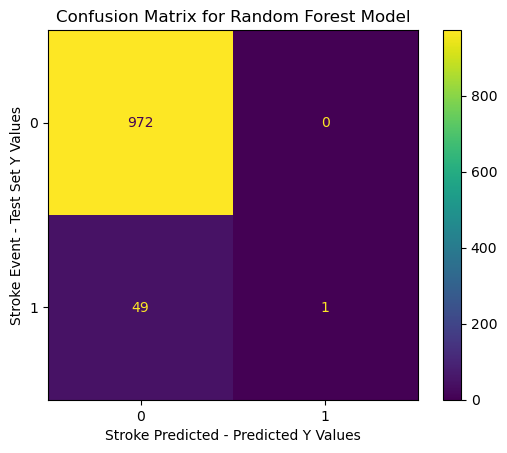

In [582]:
# Visualizing the Confusion Matrix
cm_dis_rf1 = ConfusionMatrixDisplay(cm_rf)
cm_dis_rf1.plot()
plt.title('Confusion Matrix for Random Forest Model')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [237]:
print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022



In [239]:
# Prediction probabilities
y_prob_rf1 = rf.predict_proba(X_test_scaled)
print(y_prob_rf1)

[[0.92 0.08]
 [1.   0.  ]
 [0.85 0.15]
 ...
 [0.96 0.04]
 [0.99 0.01]
 [1.   0.  ]]


In [584]:
# Calculate ROC curve
fpr_rf1, tpr_rf1, thresholds_rf1 = roc_curve(y_test, y_prob_rf1[:, 1])
# Calculate AUC
roc_auc_rf1 = auc(fpr_rf1, tpr_rf1)
print("The AUC for the Random Forest Model is:", roc_auc_rf1)

The AUC for the Random Forest Model is: 0.778888888888889


In [243]:
# Brier Score for good measure
brier_loss_rf1 = brier_score_loss(y_test, y_prob_rf1[:, 1])
print("The Brier Loss for the RandomForest Model is:", brier_loss_rf1)

The Brier Loss for the RandomForest Model is: 0.046137769080234835


### Model Adaptation

#### Oversampling

In [247]:
# Initializing RandomForest Classifier
rf_os= RandomForestClassifier(class_weight='balanced', random_state=0).fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf2 = rf_os.predict(X_test_scaled)

In [248]:
# Accuracy on training set
rf_os.score(X_train_scaled, y_train)

1.0

In [249]:
# Accuracy on test set
rf_os.score(X_test_scaled, y_test)

0.9432485322896281

In [251]:
# Confusion Matrix
cm_os = confusion_matrix(y_test, y_pred_rf2)
print("Confusion Matrix for the Random Forest Model with Oversampling:\n", cm_os)

Confusion Matrix:
 [[961  11]
 [ 47   3]]


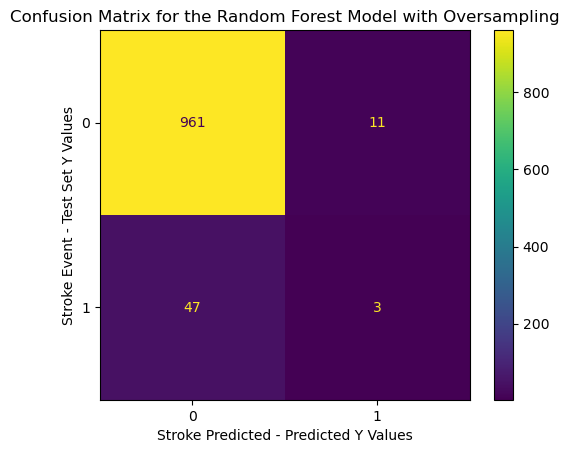

In [586]:
# Visualizing the Confusion Matrix
cm_dis_rf2 = ConfusionMatrixDisplay(cm_os)
cm_dis_rf2.plot()
plt.title('Confusion Matrix for the Random Forest Model with Oversampling')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [588]:
print("Confusion Matrix for the Random Forest Model with Oversampling:\n", classification_report(y_test, y_pred_rf2))

Confusion Matrix for the Random Forest Model with Oversampling:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.21      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.58      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022



In [259]:
# Prediction probabilities
y_prob_rf2 = rf_os.predict_proba(X_test_scaled)
print(y_prob_rf2)

[[0.9  0.1 ]
 [1.   0.  ]
 [0.82 0.18]
 ...
 [0.92 0.08]
 [0.98 0.02]
 [0.97 0.03]]


In [590]:
# Calculate ROC curve
fpr_rf2, tpr_rf2, thresholds_rf2 = roc_curve(y_test, y_prob_rf2[:, 1])
# Calculate AUC
roc_auc_rf2 = auc(fpr_rf2, tpr_rf2)
print("The AUC for the Random Forest Model with Oversampling is:", roc_auc_rf2)

The AUC for the Random Forest Model with Oversampling is: 0.7820061728395061


In [592]:
# Brier Score for good measure
brier_loss_rf2 = brier_score_loss(y_test, y_prob_rf2[:, 1])
print("The Brier Loss for the Random Forest Model with Oversampling is:", brier_loss_rf2)

The Brier Loss for the Random Forest Model with Oversampling is: 0.05227367906066536


#### Feature Selection

In [594]:
rfecv_rf = RFECV(rf, min_features_to_select=1, cv=stratified_kfold, scoring='f1')
rfecv_rf.fit(X_train_scaled, y_train)

optimal_num_features_rf = rfecv_rf.n_features_
print("Optimal number of features for the Random Forest Model: ", optimal_num_features_rf)

Optimal number of features for the Random Forest Model:  1


In [595]:
rfe2 = RFE(rf_os, n_features_to_select=optimal_num_features_rf)
rfe2 = rfe2.fit(X_train_scaled, y_train)

# Get the boolean mask of selected features
selected_features_mask2 = rfe2.support_

# Get the names of the top features
selected_feature_names2 = X_train_scaled_df.columns[selected_features_mask2]

# Print the top features
print("Selected Features:", selected_feature_names2)

Selected Features: Index(['age'], dtype='object')


In [596]:
# Assuming X_train_scaled is a pandas DataFrame
X_train_top_features2 = X_train_scaled_df.loc[:, selected_feature_names2]

# Subset test data with the same selected features
X_test_top_features2 = X_test_scaled_df.loc[:, selected_feature_names2]

# Sanity Check
print("Shape of X_train with selected features:", X_train_top_features2.shape)

Shape of X_train with selected features: (4087, 1)


In [272]:
# Train the model
rf_features = RandomForestClassifier(random_state=0, class_weight='balanced').fit(X_train_top_features2, y_train)

# Predict on test data
y_pred_rf3 = rf_features.predict(X_test_top_features2)

In [274]:
# Accuracy on training set
rf_features.score(X_train_top_features2, y_train)

0.7313432835820896

In [276]:
# Accuracy on training set
rf_features.score(X_test_top_features2, y_test)

0.7475538160469667

In [637]:
# Confusion Matrix
cm_rf_rfe = confusion_matrix(y_test, y_pred_rf3)
print("Confusion Matrix for the Random Forest Model with RFE:\n", cm_rf_rfe)

Confusion Matrix for the Random Forest Model with RFE:
 [[724 248]
 [ 10  40]]


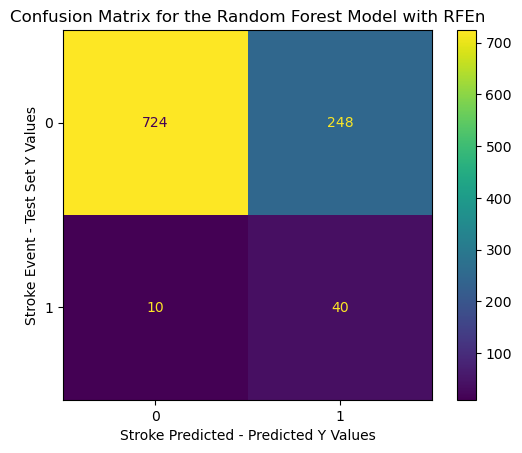

In [639]:
# Visualizing the Confusion Matrix
cm_dis_rf3 = ConfusionMatrixDisplay(cm_rf_rfe)
cm_dis_rf3.plot()
plt.title('Confusion Matrix for the Random Forest Model with RFEn')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [641]:
print("Classification Report for the Random Forest Model with RFE:\n", classification_report(y_test, y_pred_rf3))

Classification Report for the Random Forest Model with RFE:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



In [284]:
# Prediction probabilities
y_prob_rf3 = rf_features.predict_proba(X_test_top_features2)
print(y_prob_rf3)

[[1.         0.        ]
 [1.         0.        ]
 [0.62831094 0.37168906]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [0.76526847 0.23473153]]


In [643]:
# Calculate ROC curve
fpr_rf3, tpr_rf3, thresholds_rf3 = roc_curve(y_test, y_prob_rf3[:, 1])
# Calculate AUC
roc_auc_rf3 = auc(fpr_rf3, tpr_rf3)
print("The AUC for the Random Forest Model with RFE is:", roc_auc_rf3)

The AUC for the Random Forest Model with RFE is: 0.8270576131687242


In [645]:
# Brier Score for good measure
brier_loss_rf3 = brier_score_loss(y_test, y_prob_rf3[:, 1])
print("The Brier Loss for the Random Forest Model with RFE is:", brier_loss_rf3)

The Brier Loss for the Random Forest Model with RFE is: 0.16281934171599796


#### Hyperparameter Tuning

##### Comment

Just a heads up, the parameter search for Random Forest can take a while - so don't be discouraged.
It took my li'l ol' piece of metal about three minutes.

In [292]:
param_grid_rf = {
    'n_estimators': [25, 50, 75 ],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=stratified_kfold, scoring='f1', n_jobs=-1)

# Fit GridSearchCV
grid_search_rf.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 25}
Best Score: 0.2276882371259271


In [294]:
# RandomForest model with the best parameters
best_params_rf = grid_search_rf.best_params_ 
rf_params = RandomForestClassifier(**best_params_rf, random_state=0, class_weight='balanced').fit(X_train_scaled, y_train)

y_pred_rf4 = rf_params.predict(X_test_scaled)

In [296]:
# Accuracy on training set
rf_params.score(X_train_scaled, y_train)

0.9701492537313433

In [298]:
# Accuracy on test set
rf_params.score(X_test_scaled, y_test)

0.8669275929549902

In [617]:
# Confusion Matrix
cm_rf_params = confusion_matrix(y_test, y_pred_rf4)
print("Confusion Matrix for the Random Forest Model with Hyperparameter Tuning:\n", cm_rf_params)

Confusion Matrix for the Random Forest Model with Hyperparameter Tuning:
 [[868 104]
 [ 32  18]]


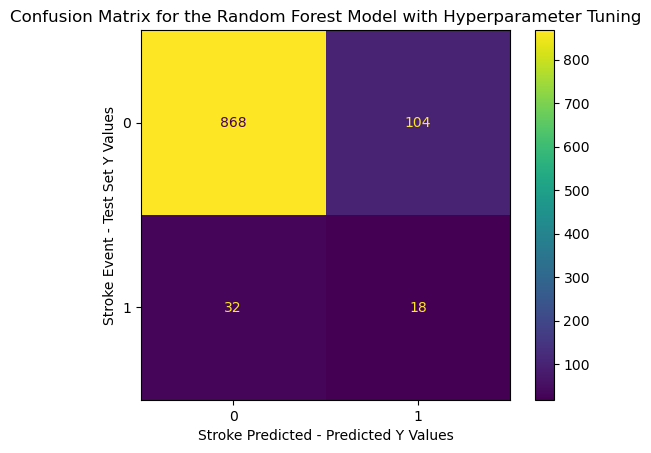

In [619]:
# Visualizing the Confusion Matrix
cm_dis_param = ConfusionMatrixDisplay(cm_rf_params)
cm_dis_param.plot()
plt.title('Confusion Matrix for the Random Forest Model with Hyperparameter Tuning')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [621]:
print("Confusion Matrix for the Random Forest Model with Hyperparameter Tuning: \n",classification_report(y_test, y_pred_rf4))

Confusion Matrix for the Random Forest Model with Hyperparameter Tuning: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93       972
           1       0.15      0.36      0.21        50

    accuracy                           0.87      1022
   macro avg       0.56      0.63      0.57      1022
weighted avg       0.92      0.87      0.89      1022



In [306]:
# Prediction probabilities
y_prob_rf4 = rf_params.predict_proba(X_test_scaled)
print(y_prob_rf4)

[[0.71929599 0.28070401]
 [0.99441497 0.00558503]
 [0.77677729 0.22322271]
 ...
 [0.77770956 0.22229044]
 [0.96532441 0.03467559]
 [0.92727205 0.07272795]]


In [623]:
# Calculate ROC curve
fpr_rf4, tpr_rf4, thresholds_rf4 = roc_curve(y_test, y_prob_rf4[:, 1])
# Calculate AUC
roc_auc_rf4 = auc(fpr_rf4, tpr_rf4)
print("The AUC for the Random Forest Model with Hyperparameter Tuning is:", roc_auc_rf4)

The AUC for the Random Forest Model with Hyperparameter Tuning is: 0.7936008230452674


In [625]:
# Brier Score for good measure
brier_loss_rf4 = brier_score_loss(y_test, y_prob_rf4[:, 1])
print("The Brier Loss for the Random Forest Model with Hyperparameter Tuning is:", brier_loss_rf4)

The Brier Loss for the Random Forest Model with Hyperparameter Tuning is: 0.09128872755230492


### Model Comparison - RandomForest

In [635]:
auc_rf = {
    'Random Forest Model': roc_auc_rf1,
    'Random Forest Model with Oversampling': roc_auc_rf2,
    'Random Forest Model with RFE': roc_auc_rf3,
    'Random Forest Model with Hyperparameter Tuning': roc_auc_rf4
}

# Create a DataFrame
df_auc_rf = pd.DataFrame(list(auc_rf.items()), columns=['Model', 'AUC'])

# Display the DataFrame
display(HTML(f"<h4>{'Area Under Curve for Random Forest Models'}</h4>"))
df_auc_rf.head()

,Model,AUC
0,Random Forest Model,0.778889
1,Random Forest Model with Oversampling,0.782006
2,Random Forest Model with RFE,0.827058
3,Random Forest Model with Hyperparameter Tuning,0.793601


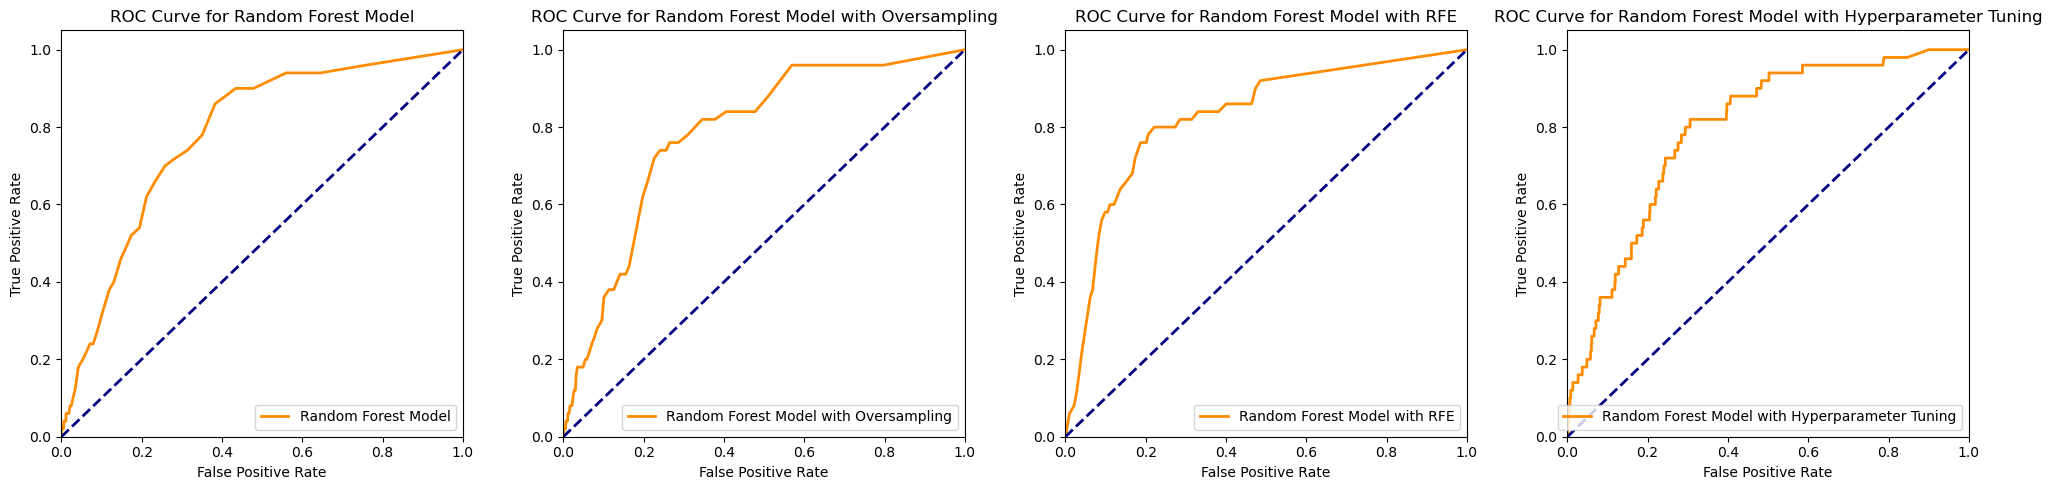

In [633]:
# Example data for multiple ROC curves
roc_curves_rf = [
    {'fpr': fpr_rf1, 'tpr': tpr_rf1, 'label': 'Random Forest Model'},
    {'fpr': fpr_rf2, 'tpr': tpr_rf2, 'label': 'Random Forest Model with Oversampling'},
    {'fpr': fpr_rf3, 'tpr': tpr_rf3, 'label': 'Random Forest Model with RFE'},
    {'fpr': fpr_rf4, 'tpr': tpr_rf4, 'label': 'Random Forest Model with Hyperparameter Tuning'}
]

# Number of plots
num_plots_rf = len(roc_curves_rf)

# Create subplots (adjust rows and columns as needed)
fig, axes = plt.subplots(1, num_plots_rf, figsize=(20, 5))

# Plot each ROC curve
for i, roc in enumerate(roc_curves_rf):
    ax = axes[i]  # Select the appropriate subplot
    ax.plot(roc['fpr'], roc['tpr'], color='darkorange', lw=2, label=roc['label'])
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {roc["label"]}')
    ax.legend(loc='lower right')
display(HTML(f"<h4>{'ROC Curves for Random Forest Models'}</h4>"))
plt.tight_layout()
plt.show()

In [317]:
brier_scores_rf = {
    'Random Forest Model': brier_loss_rf1,
    'Random Forest Model with Oversampling': brier_loss_rf2,
    'Random Forest Model with RFE': brier_loss_rf3,
    'Random Forest Model with Hyperparameter Tuning': brier_loss_rf4
}

# Create a DataFrame
df_brier_scores_rf = pd.DataFrame(list(brier_scores_rf.items()), columns=['Model', 'Brier Score'])

# Display the DataFrame
display(HTML(f"<h4>{'Brier Loss Scores for Random Forest Models'}</h4>"))
df_brier_scores_rf.head()

,Model,Brier Score
0,Random Forest Model,0.046138
1,Random Forest Model with Oversampling,0.052274
2,Random Forest Model with RFE,0.162819
3,Random Forest Model with Hyperparameter Tuning,0.091289


In [647]:
reports_rf = {
    'Model': ['Random Forest', 'Random Forest with Oversampling', 
              'Random Forest with RFE', 
              'Random Forest with Hyperparameter Tuning'],
  'Precision (Majority)': [
        classification_report(y_test, y_pred_rf1, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_rf2, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_rf3, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_rf4, output_dict=True)['0']['precision']
    ],
     'Precision (Minority)': [
        classification_report(y_test, y_pred_rf1, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf2, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf3, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf4, output_dict=True)['1']['precision']
    ],
    'Recall (Majority)': [
        classification_report(y_test, y_pred_rf1, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_rf2, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_rf3, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_rf4, output_dict=True)['0']['recall']
    ],
    'Recall (Minority)': [
        classification_report(y_test, y_pred_rf1, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf2, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf3, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf4, output_dict=True)['1']['recall']
    ],
    'F1-Score (Majority)': [
        classification_report(y_test, y_pred_rf1, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_rf2, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_rf3, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_rf4, output_dict=True)['0']['f1-score']
    ],
    'F1-Score (Minority)': [
        classification_report(y_test, y_pred_rf1, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf2, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf3, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf4, output_dict=True)['1']['f1-score']
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf1),
        accuracy_score(y_test, y_pred_rf2),
        accuracy_score(y_test, y_pred_rf3),
        accuracy_score(y_test, y_pred_rf4)
    ] }

df_report_rf = pd.DataFrame(reports_rf)

# Display the DataFrame as an HTML table
display(HTML(f"<h4>Classification Reports for Random Forest Model Adaptation</h4>"))
display(df_report_rf)

,Model,Precision (Majority),Precision (Minority),Recall (Majority),Recall (Minority),F1-Score (Majority),F1-Score (Minority),Accuracy
0,Random Forest,0.952008,1.000000,1.000000,0.02,0.975414,0.039216,0.952055
1,Random Forest with Oversampling,0.953373,0.214286,0.988683,0.06,0.970707,0.093750,0.943249
2,Random Forest with RFE,0.986376,0.138889,0.744856,0.80,0.848769,0.236686,0.747554
3,Random Forest with Hyperparameter Tuning,0.964444,0.147541,0.893004,0.36,0.927350,0.209302,0.866928


## Support Vector Machine

### Model Building

In [323]:
# Initialize SVM model
svm_1 = SVC(class_weight='balanced', kernel='rbf', probability=True)

# Fit model
svm_1.fit(X_train_scaled, y_train.values.ravel())

# Make predictions
y_pred_svm1 = svm_1.predict(X_test_scaled)

### Model Evaluation

In [325]:
# Accuracy on training set
svm_1.score(X_train_scaled, y_train)

0.7714705162711035

In [326]:
# Accuracy on test set
svm_1.score(X_test_scaled, y_test)

0.6761252446183953

In [651]:
# Compute the confusion matrix
cm_svm1 = confusion_matrix(y_test, y_pred_svm1)
print("Confusion Matrix for Support Vector Machine:\n", cm_svm1)

Confusion Matrix for Support Vector Machine:
 [[662 310]
 [ 21  29]]


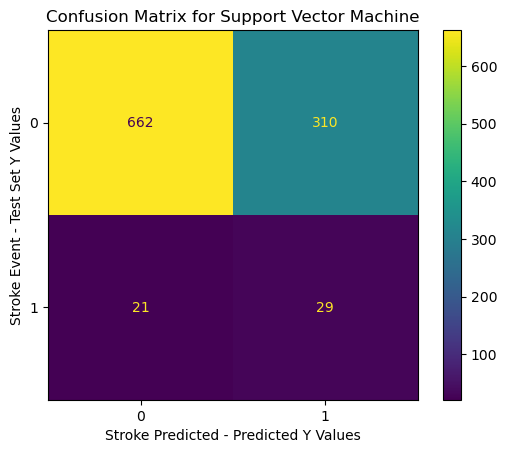

In [649]:
# Visualizing the Confusion Matrix
cm_dis_svm1 = ConfusionMatrixDisplay(cm_svm1)
cm_dis_svm1.plot()
plt.title('Confusion Matrix for Support Vector Machine')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [653]:
# Classification report
print("Classification Report for Support Vector Machine:\n", classification_report(y_test, y_pred_svm1))

Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

           0       0.97      0.68      0.80       972
           1       0.09      0.58      0.15        50

    accuracy                           0.68      1022
   macro avg       0.53      0.63      0.47      1022
weighted avg       0.93      0.68      0.77      1022



In [336]:
# Prediction probabilities
y_prob_svm1 = svm_1.predict_proba(X_test_scaled)
print(y_prob_svm1)

[[0.91789136 0.08210864]
 [0.98706915 0.01293085]
 [0.86709004 0.13290996]
 ...
 [0.93541318 0.06458682]
 [0.99447646 0.00552354]
 [0.9723676  0.0276324 ]]


In [338]:
# Calculate ROC curve
fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(y_test, y_prob_svm1[:, 1])
# Calculate AUC
roc_auc_svm1 = auc(fpr_svm1, tpr_svm1)
print("The AUC for the Support Vector Machine Model is:", roc_auc_svm1)

The AUC for the Support Vector Machine Model is: 0.707798353909465


In [340]:
# Brier Score for good measure
brier_loss_svm1 = brier_score_loss(y_test, y_prob_svm1[:, 1])
print("The Brier Loss for the Support Vector Machine Model is:", brier_loss_svm1)

The Brier Loss for the Support Vector Machine Model is: 0.046620141467382366


### Model Adaptation

#### Oversampling

In [344]:
# Initializing SupportVectorMachine
svm_2 = SVC(class_weight='balanced', random_state=0, kernel = 'rbf', probability=True).fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_svm2 = svm_2.predict(X_test_scaled)

In [345]:
# Accuracy on training set
svm_2.score(X_train_resampled, y_train_resampled)

0.866383744855967

In [346]:
# Accuracy on test set
svm_2.score(X_test_scaled, y_test)

0.7455968688845401

In [347]:
# Confusion Matrix
cm_svm2 = confusion_matrix(y_test, y_pred_svm2)
print("Confusion Matrix for SVM with Oversampling:\n", cm_svm2)

Confusion Matrix:
 [[739 233]
 [ 27  23]]


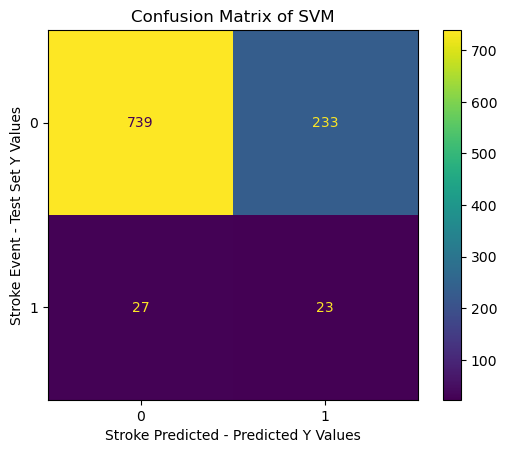

In [348]:
# Visualizing the Confusion Matrix
cm_dis_svm2 = ConfusionMatrixDisplay(cm_svm2)
cm_dis_svm2.plot()
plt.title('Confusion Matrix of SVM with Oversampling')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [657]:
print("Classification Report for SVM with Oversampling:\n", classification_report(y_test, y_pred_svm2))

Classification Report for SVM with Oversampling:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85       972
           1       0.09      0.46      0.15        50

    accuracy                           0.75      1022
   macro avg       0.53      0.61      0.50      1022
weighted avg       0.92      0.75      0.82      1022



In [350]:
# Prediction probabilities
y_prob_svm2 = svm_2.predict_proba(X_test_scaled)
print(y_prob_svm2)

[[7.49421285e-01 2.50578715e-01]
 [9.98107388e-01 1.89261219e-03]
 [1.05704647e-01 8.94295353e-01]
 ...
 [7.23188712e-01 2.76811288e-01]
 [9.99769937e-01 2.30063152e-04]
 [9.45064681e-01 5.49353188e-02]]


In [659]:
# Calculate ROC curve
fpr_svm2, tpr_svm2, thresholds_svm2 = roc_curve(y_test, y_prob_svm2[:, 1])
# Calculate AUC
roc_auc_svm2 = auc(fpr_svm2, tpr_svm2)
print("The AUC for the SVM with Oversampling is:", roc_auc_svm2)

The AUC for the SVM with Oversampling is: 0.7120781893004116


In [661]:
# Brier Score for good measure
brier_loss_svm2 = brier_score_loss(y_test, y_prob_svm2[:, 1])
print("The Brier Loss for the SVM with Oversampling is:", brier_loss_svm2)

The Brier Loss for the SVM with Oversampling is: 0.15196263802143978


#### Feature Selection

In [363]:
lasso = LassoCV().fit(X_train_scaled, y_train)
importance = np.abs(lasso.coef_)

# Print feature importances
print("Feature Importances:")
for i, imp in enumerate(importance):
    print(f"Feature {i+1} (Column {i}): {imp}")

Feature Importances:
Feature 1 (Column 0): 0.10206809352610802
Feature 2 (Column 1): 0.041508720412038236
Feature 3 (Column 2): 0.02461547882872838
Feature 4 (Column 3): 0.01046183700612367
Feature 5 (Column 4): 0.0012304424401171554
Feature 6 (Column 5): 0.0
Feature 7 (Column 6): 0.03063749259981788
Feature 8 (Column 7): 0.0
Feature 9 (Column 8): 9.555231949204726e-05
Feature 10 (Column 9): 0.0020935066266260477
Feature 11 (Column 10): 0.03855342120120309
Feature 12 (Column 11): 0.002518110681695818
Feature 13 (Column 12): 0.0
Feature 14 (Column 13): 0.0060032050360504605
Feature 15 (Column 14): 0.0


In [365]:
# Feature Indices for finding features
top_features_indices = np.argsort(importance)[-3:]  # Indices of the top 5 features
top_features_indices_sorted = np.sort(top_features_indices)
print(f"Top 3 sorted feature indices: {top_features_indices_sorted}")

Top 3 sorted feature indices: [ 0  1 10]


In [367]:
print("Top 3 Features:")
for i in top_features_indices_sorted:
    feature_name = X_train_resampled_df.columns[i]
    print(f"Feature '{feature_name}' (Column {i}): {importance[i]}")

Top 3 Features:
Feature 'age' (Column 0): 0.10206809352610802
Feature 'hypertension' (Column 1): 0.041508720412038236
Feature 'work_type_children' (Column 10): 0.03855342120120309


In [369]:
feature_names_list = [X_train_scaled_df.columns[i] for i in top_features_indices_sorted]

#for i in top_features_indices_sorted:
    #feature_name = X_train_scaled_df.columns[i]
    #print(f"Feature '{feature_name}' (Column {i}): {importance[i]}")
    
# Filter the dataset to keep only the top 5 features
X_train_top = X_train_scaled[:, top_features_indices_sorted]
X_test_top = X_test_scaled[:, top_features_indices_sorted]  # Apply the same filtering to test data

print(f"Shape of X_train_top: {X_train_top.shape}")
print(f"Shape of X_test_top: {X_test_top.shape}")

Shape of X_train_top: (4087, 3)
Shape of X_test_top: (1022, 3)


In [371]:
X_train_top_df = pd.DataFrame(X_train_top, columns=feature_names_list)
X_test_top_df = pd.DataFrame(X_test_top, columns=feature_names_list)

# Initialize and train the SVM model
svm_3 = SVC(class_weight='balanced', random_state=0, kernel='rbf', probability=True)
svm_3.fit(X_train_top_df, y_train)

# Predict on the test set using the trained model
y_pred_svm3 = svm_3.predict(X_test_top_df)

In [372]:
# Accuracy on training set
svm_3.score(X_train_top, y_train)

0.6430144360166381

In [373]:
# Accuracy on test set
svm_3.score(X_test_top, y_test)

0.6340508806262231

In [663]:
# Confusion Matrix
cm_svm3 = confusion_matrix(y_test, y_pred_svm3)
print("Confusion Matrix for SVM with Feature Selection:\n", cm_svm3)

Confusion Matrix for SVM with Feature Selection:
 [[606 366]
 [  8  42]]


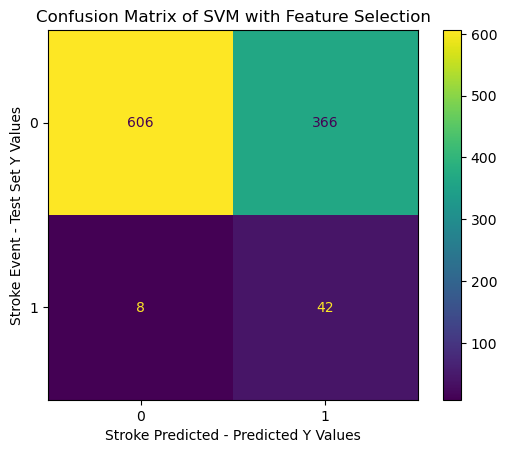

In [665]:
# Visualizing the Confusion Matrix
cm_dis_svm3 = ConfusionMatrixDisplay(cm_svm3)
cm_dis_svm3.plot()
plt.title('Confusion Matrix of SVM with Feature Selection')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [667]:
print("Classification Report for SVM with Feature Selection:\n", classification_report(y_test, y_pred_svm3))

Classification Report for SVM with Feature Selection:
               precision    recall  f1-score   support

           0       0.99      0.62      0.76       972
           1       0.10      0.84      0.18        50

    accuracy                           0.63      1022
   macro avg       0.54      0.73      0.47      1022
weighted avg       0.94      0.63      0.74      1022



In [669]:
# Prediction probabilities
y_prob_svm3 = svm_3.predict_proba(X_test_top)
print(y_prob_svm3)

[[0.99477097 0.00522903]
 [0.99083906 0.00916094]
 [0.95890036 0.04109964]
 ...
 [0.99793514 0.00206486]
 [0.99485337 0.00514663]
 [0.9908109  0.0091891 ]]


In [671]:
# Calculate ROC curve
fpr_svm3, tpr_svm3, thresholds_svm3 = roc_curve(y_test, y_prob_svm3[:, 1])
# Calculate AUC
roc_auc_svm3 = auc(fpr_svm3, tpr_svm3)
print("The AUC for the Support Vector Machine Model with Feature Selection is:", roc_auc_svm3)

The AUC for the Support Vector Machine Model with Feature Selection is: 0.7642592592592594


In [673]:
# Brier Score for good measure
brier_loss_svm3 = brier_score_loss(y_test, y_prob_svm3[:, 1])
print("The Brier Loss for the Support Vector Machine Model with Feature Selection is:", brier_loss_svm3)

The Brier Loss for the Support Vector Machine Model with Feature Selection is: 0.043781990186092516


#### Hyperparameters

In [390]:
# Define parameter distributions
param_dist_svm = {
    'C': uniform(0.1, 5),  # Uniform distribution over [0.1, 100]
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel type
    'gamma': [0.1, 0.5, 1] ,  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}


# Initialize RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    svm_1, 
    param_distributions=param_dist_svm, 
    n_iter=50,  # Number of parameter combinations to sample
    cv=stratified_kfold,  # Number of cross-validation folds
    scoring='f1',  # Scoring metric
    n_jobs=-1,  # Number of parallel jobs to run
    random_state=42  # For reproducibility
)

# Fit RandomizedSearchCV
random_search_svm.fit(X_train_scaled, y_train)

# Print best parameters and best score
print("Best Parameters SVM:", random_search_svm.best_params_)
print("Best Score SVM:", random_search_svm.best_score_)

Best Parameters SVM: {'C': 3.9563517334297287, 'gamma': 0.1, 'kernel': 'poly'}
Best Score SVM: 0.22869392787523193


In [392]:
# RandomForest model with the best parameters
best_params_svm = random_search_svm.best_params_  # Make sure to capture best_params
svm_4 = svm.SVC(**best_params_svm, random_state=0, class_weight='balanced', probability=True).fit(X_train_scaled, y_train)

y_pred_svm4 = svm_4.predict(X_test_scaled)

In [675]:
# Confusion Matrix
cm_svm_4 = confusion_matrix(y_test, y_pred_svm4)
print("Confusion Matrix for SVM with Hyperparameter Tuning:\n", cm_svm_4)

Confusion Matrix for SVM with Hyperparameter Tuning:
 [[580 392]
 [  8  42]]


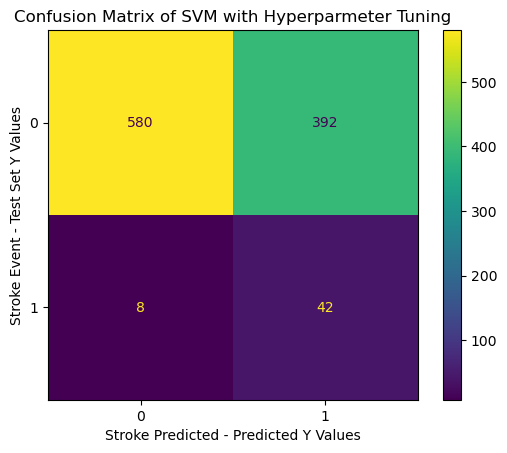

In [677]:
# Visualizing the Confusion Matrix
cm_dis_svm4 = ConfusionMatrixDisplay(cm_svm_4)
cm_dis_svm4.plot()
plt.title('Confusion Matrix of SVM with Hyperparmeter Tuning')
plt.ylabel('Stroke Event - Test Set Y Values')
plt.xlabel('Stroke Predicted - Predicted Y Values')
plt.show()

In [679]:
print("Classification Report for SVM with Hyperparameter Tuning:\n",classification_report(y_test, y_pred_svm4))

Classification Report for SVM with Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.99      0.60      0.74       972
           1       0.10      0.84      0.17        50

    accuracy                           0.61      1022
   macro avg       0.54      0.72      0.46      1022
weighted avg       0.94      0.61      0.72      1022



In [400]:
# Prediction probabilities
y_prob_svm4 = svm_4.predict_proba(X_test_scaled)
print(y_prob_svm4)

[[9.38115751e-01 6.18842490e-02]
 [9.99891481e-01 1.08518823e-04]
 [9.16685738e-01 8.33142624e-02]
 ...
 [9.72655616e-01 2.73443839e-02]
 [9.96019527e-01 3.98047321e-03]
 [9.59060387e-01 4.09396127e-02]]


In [402]:
# Calculate ROC curve
fpr_svm4, tpr_svm4, thresholds_svm4 = roc_curve(y_test, y_prob_svm4[:, 1])
# Calculate AUC
roc_auc_svm4 = auc(fpr_svm4, tpr_svm4)
print("The AUC for the SVM with Hyperparameter Tuning is:", roc_auc_svm4)

The AUC for the Support Vector Machine Model is: 0.8067901234567901


In [404]:
# Brier Score for good measure
brier_loss_svm4 = brier_score_loss(y_test, y_prob_svm4[:, 1])
print("The Brier Loss for the SVM with Hyperparameter Tuning is:", brier_loss_svm4)

The Brier Loss for the Support Vector Machine Model is: 0.11645163976670718


### Model Comparison

In [681]:
auc_svm = {
    'Support Vector Machine Model': roc_auc_svm1,
    'Support Vector Machine Model with Oversampling': roc_auc_svm2,
    'Support Vector Machine Model with Feature Selection': roc_auc_svm3,
    'Support Vector Machine Model with Hyperparameter Tuning': roc_auc_svm4
}

# Create a DataFrame
df_auc_svm = pd.DataFrame(list(auc_svm.items()), columns=['Model', 'AUC'])

# Display the DataFrame
display(HTML(f"<h4>{'Area Under Curve for Logistic Regression Models'}</h4>"))
df_auc_svm.head()

,Model,AUC
0,Support Vector Machine Model,0.707798
1,Support Vector Machine Model with Oversampling,0.712078
2,Support Vector Machine Model with Feature Sele...,0.764259
3,Support Vector Machine Model with Hyperparamet...,0.806790


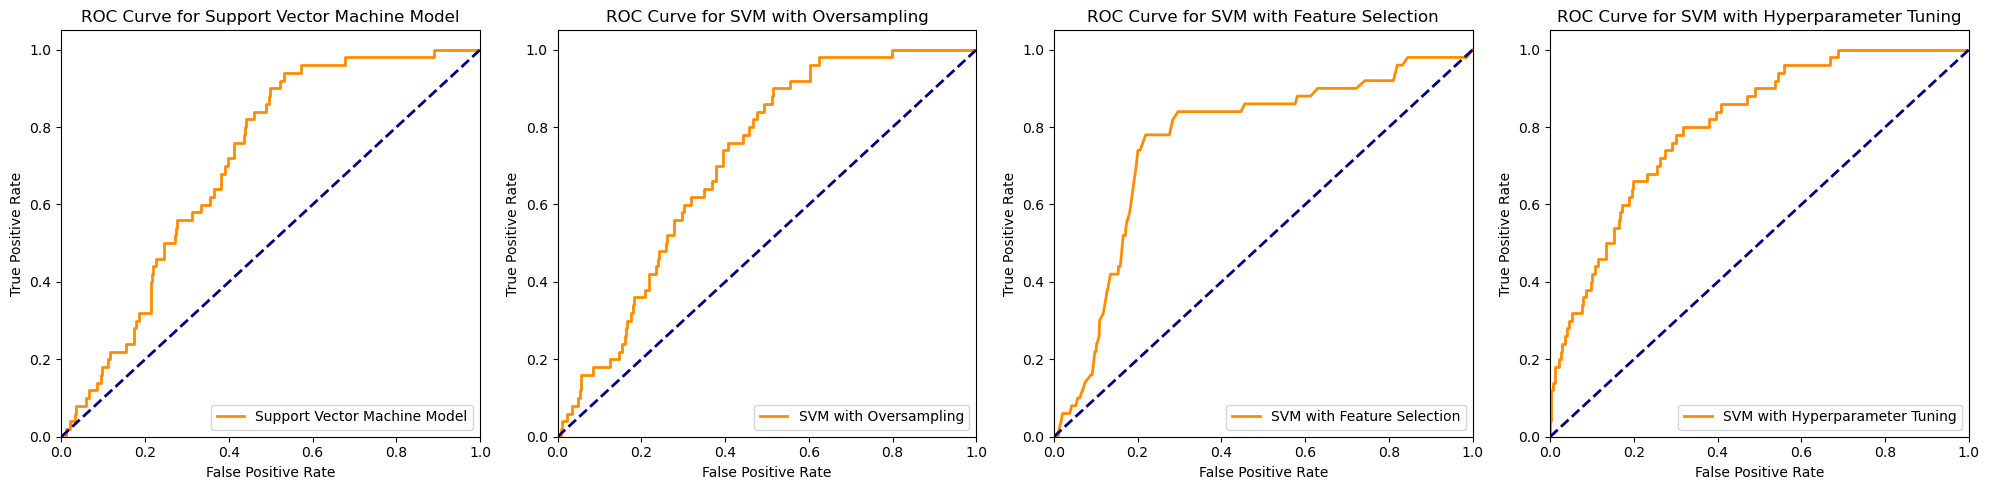

In [683]:
# Example data for multiple ROC curves
roc_curves_svm = [
    {'fpr': fpr_svm1, 'tpr': tpr_svm1, 'label': 'Support Vector Machine Model'},
    {'fpr': fpr_svm2, 'tpr': tpr_svm2, 'label': 'SVM with Oversampling'},
    {'fpr': fpr_svm3, 'tpr': tpr_svm3, 'label': 'SVM with Feature Selection'},
    {'fpr': fpr_svm4, 'tpr': tpr_svm4, 'label': 'SVM with Hyperparameter Tuning'}
]

# Number of plots
num_plots_svm = len(roc_curves_svm)

# Create subplots (adjust rows and columns as needed)
fig, axes = plt.subplots(1, num_plots_svm, figsize=(20, 5))

# Plot each ROC curve
for i, roc in enumerate(roc_curves_svm):
    ax = axes[i]  # Select the appropriate subplot
    ax.plot(roc['fpr'], roc['tpr'], color='darkorange', lw=2, label=roc['label'])
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {roc["label"]}')
    ax.legend(loc='lower right')
display(HTML(f"<h4>{'ROC Curves for Support Vector Machine Models'}</h4>"))
plt.tight_layout()
plt.show()

In [685]:
brier_scores_svm = {
    'Support Vector Machine Model': brier_loss_svm1,
    'SVM with Oversampling': brier_loss_svm2,
    'SVM with Feature Selection': brier_loss_svm3,
    'SVM with Hyperparameter Tuning': brier_loss_svm4
}

# Create a DataFrame
df_brier_scores_svm = pd.DataFrame(list(brier_scores_svm.items()), columns=['Model', 'Brier Score'])

# Display the DataFrame
display(HTML(f"<h4>{'Brier Loss Scores for Support Vector Machine Models'}</h4>"))
df_brier_scores_svm.head()

,Model,Brier Score
0,Support Vector Machine Model,0.046620
1,SVM with Oversampling,0.151963
2,SVM with Feature Selection,0.043782
3,SVM with Hyperparameter Tuning,0.116452


In [687]:
reports_svm = {
    'Model': ['Support Vector Machine', 'SVM with Oversampling', 
              'SVM with Feature Selection', 
              'SVM with Hyperparameter Tuning'],
    'Precision (Majority)': [
        classification_report(y_test, y_pred_svm1, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_svm2, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_svm3, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_svm4, output_dict=True)['0']['precision']
    ],
     'Precision (Minority)': [
        classification_report(y_test, y_pred_svm1, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_svm2, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_svm3, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_svm4, output_dict=True)['1']['precision']
    ],
    'Recall (Majority)': [
        classification_report(y_test, y_pred_svm1, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_svm2, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_svm3, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_svm4, output_dict=True)['0']['recall']
    ],
    'Recall (Minority)': [
        classification_report(y_test, y_pred_svm1, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_svm2, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_svm3, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_svm4, output_dict=True)['1']['recall']
    ],
    'F1-Score (Majority)': [
        classification_report(y_test, y_pred_svm1, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_svm2, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_svm3, output_dict=True)['0']['f1-score'],
        classification_report(y_test, y_pred_svm4, output_dict=True)['0']['f1-score']
    ],
    'F1-Score (Minority)': [
        classification_report(y_test, y_pred_svm1, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_svm2, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_svm3, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_svm4, output_dict=True)['1']['f1-score']
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_svm1),
        accuracy_score(y_test, y_pred_svm2),
        accuracy_score(y_test, y_pred_svm3),
        accuracy_score(y_test, y_pred_svm4)
    ]
}

df_report_svm = pd.DataFrame(reports_svm)

# Display the DataFrame as an HTML table
display(HTML(f"<h4>Classification Reports for Support Vector Machine Models</h4>"))
display(df_report_svm)

,Model,Precision (Majority),Precision (Minority),Recall (Majority),Recall (Minority),F1-Score (Majority),F1-Score (Minority),Accuracy
0,Support Vector Machine,0.969253,0.085546,0.681070,0.58,0.800000,0.149100,0.676125
1,SVM with Oversampling,0.964752,0.089844,0.760288,0.46,0.850403,0.150327,0.745597
2,SVM with Feature Selection,0.986971,0.102941,0.623457,0.84,0.764187,0.183406,0.634051
3,SVM with Hyperparameter Tuning,0.986395,0.096774,0.596708,0.84,0.743590,0.173554,0.608611


# To stroke or not to stroke - Comparative Analysis

In [690]:
# Combine all classification reports
df_report_all = pd.concat([df_report_svm, df_report_rf, df_report_svm], ignore_index=True)

# Sort the combined DataFrame by the 'Precision' column in descending order
df_class_sorted = df_report_all.sort_values(by='F1-Score (Minority)', ascending=False)

# Reset the index to maintain consistency after sorting
df_class_sorted.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame as an HTML table
display(HTML(f"<h4>Classification Reports for all Models (sorted by F1-Score (Minority))</h4>"))
display(df_class_sorted)

,Model,Precision (Majority),Precision (Minority),Recall (Majority),Recall (Minority),F1-Score (Majority),F1-Score (Minority),Accuracy
0,Random Forest with RFE,0.986376,0.138889,0.744856,0.80,0.848769,0.236686,0.747554
1,Random Forest with Hyperparameter Tuning,0.964444,0.147541,0.893004,0.36,0.927350,0.209302,0.866928
2,SVM with Feature Selection,0.986971,0.102941,0.623457,0.84,0.764187,0.183406,0.634051
3,SVM with Feature Selection,0.986971,0.102941,0.623457,0.84,0.764187,0.183406,0.634051
4,SVM with Hyperparameter Tuning,0.986395,0.096774,0.596708,0.84,0.743590,0.173554,0.608611
5,SVM with Hyperparameter Tuning,0.986395,0.096774,0.596708,0.84,0.743590,0.173554,0.608611
6,SVM with Oversampling,0.964752,0.089844,0.760288,0.46,0.850403,0.150327,0.745597
7,SVM with Oversampling,0.964752,0.089844,0.760288,0.46,0.850403,0.150327,0.745597
8,Support Vector Machine,0.969253,0.085546,0.681070,0.58,0.800000,0.149100,0.676125
9,Support Vector Machine,0.969253,0.085546,0.681070,0.58,0.800000,0.149100,0.676125


##### Comment

When comparing the confusion matrices for all models on the basis of the F1-Score for the minority, the best performing model ist the Random Forest with Feature Selection. This model has an F1-Score for the Minority of 0.24, and an accuracy of 74,75%. However, it still performs significantly better on the majority group due to imbalances in the target variable 'stroke'.

The second best performing model on the basis of the F1-Score is the Random Forest Model with Hyperparameter Tuning. It has an F1-Score (Minority) of 0.21 and an accuracy of 86,7%.

On the basis of the F1-Scores and Accuracy of all tested models, the best model from my perspective would be the Random Forest Model with Feature Selection. However, this model consists of only one feature ('age') as predictor for stroke risk, which has very limited informational value for us.
Therefore, an argument for the Random Forest with Hyperparameter Tuning could be made since here we kept all variables as predictors.

Let's also keep in mind that based on the classification report, the Support Vector Machine with Feature Selection is a moderate performer with an F1-Score (Minority) of 0.18 and an accuracy of 0.63.

Before we make a final decision, let's take a look at the Brier Scores and ROC / AUC as well.

In [693]:
# Combine all Brier Loss Scores
df_brier_all = pd.concat([df_brier_scores_log, df_brier_scores_rf, df_brier_scores_svm], ignore_index=True)

# Sort the combined DataFrame by the 'Precision' column in descending order
df_brier_sorted = df_brier_all.sort_values(by='Brier Score', ascending=True)

# Reset the index to maintain consistency after sorting
df_brier_sorted.reset_index(drop=True, inplace=True)

# Display the DataFrame as an HTML table
display(HTML(f"<h4>Brier Scores for all Models )</h4>"))
display(df_brier_sorted)

,Model,Brier Score
0,SVM with Feature Selection,0.043782
1,Random Forest Model,0.046138
2,Support Vector Machine Model,0.046620
3,Random Forest Model with Oversampling,0.052274
4,Random Forest Model with Hyperparameter Tuning,0.091289
5,SVM with Hyperparameter Tuning,0.116452
6,SVM with Oversampling,0.151963
7,Random Forest Model with RFE,0.162819
8,Logistic Regression Model with Oversampling,0.208820
9,Logistic Regression Model with RFE,0.208820


##### Comment

According to the Brier Loss Score, the best performing models here are the Support Vector Machine with RFE (0.044) and the base Random Forest Model (0.046).

Models in the "middle-field" are Support Vector Machine Model with Oversampling (0.152) and the Random Forest Model with RFE (0.163).

The models with highest loss are the Logistic Regression Model (0.219) and the Logistic Regression Model with Hyperparameter Tuning (0.219).

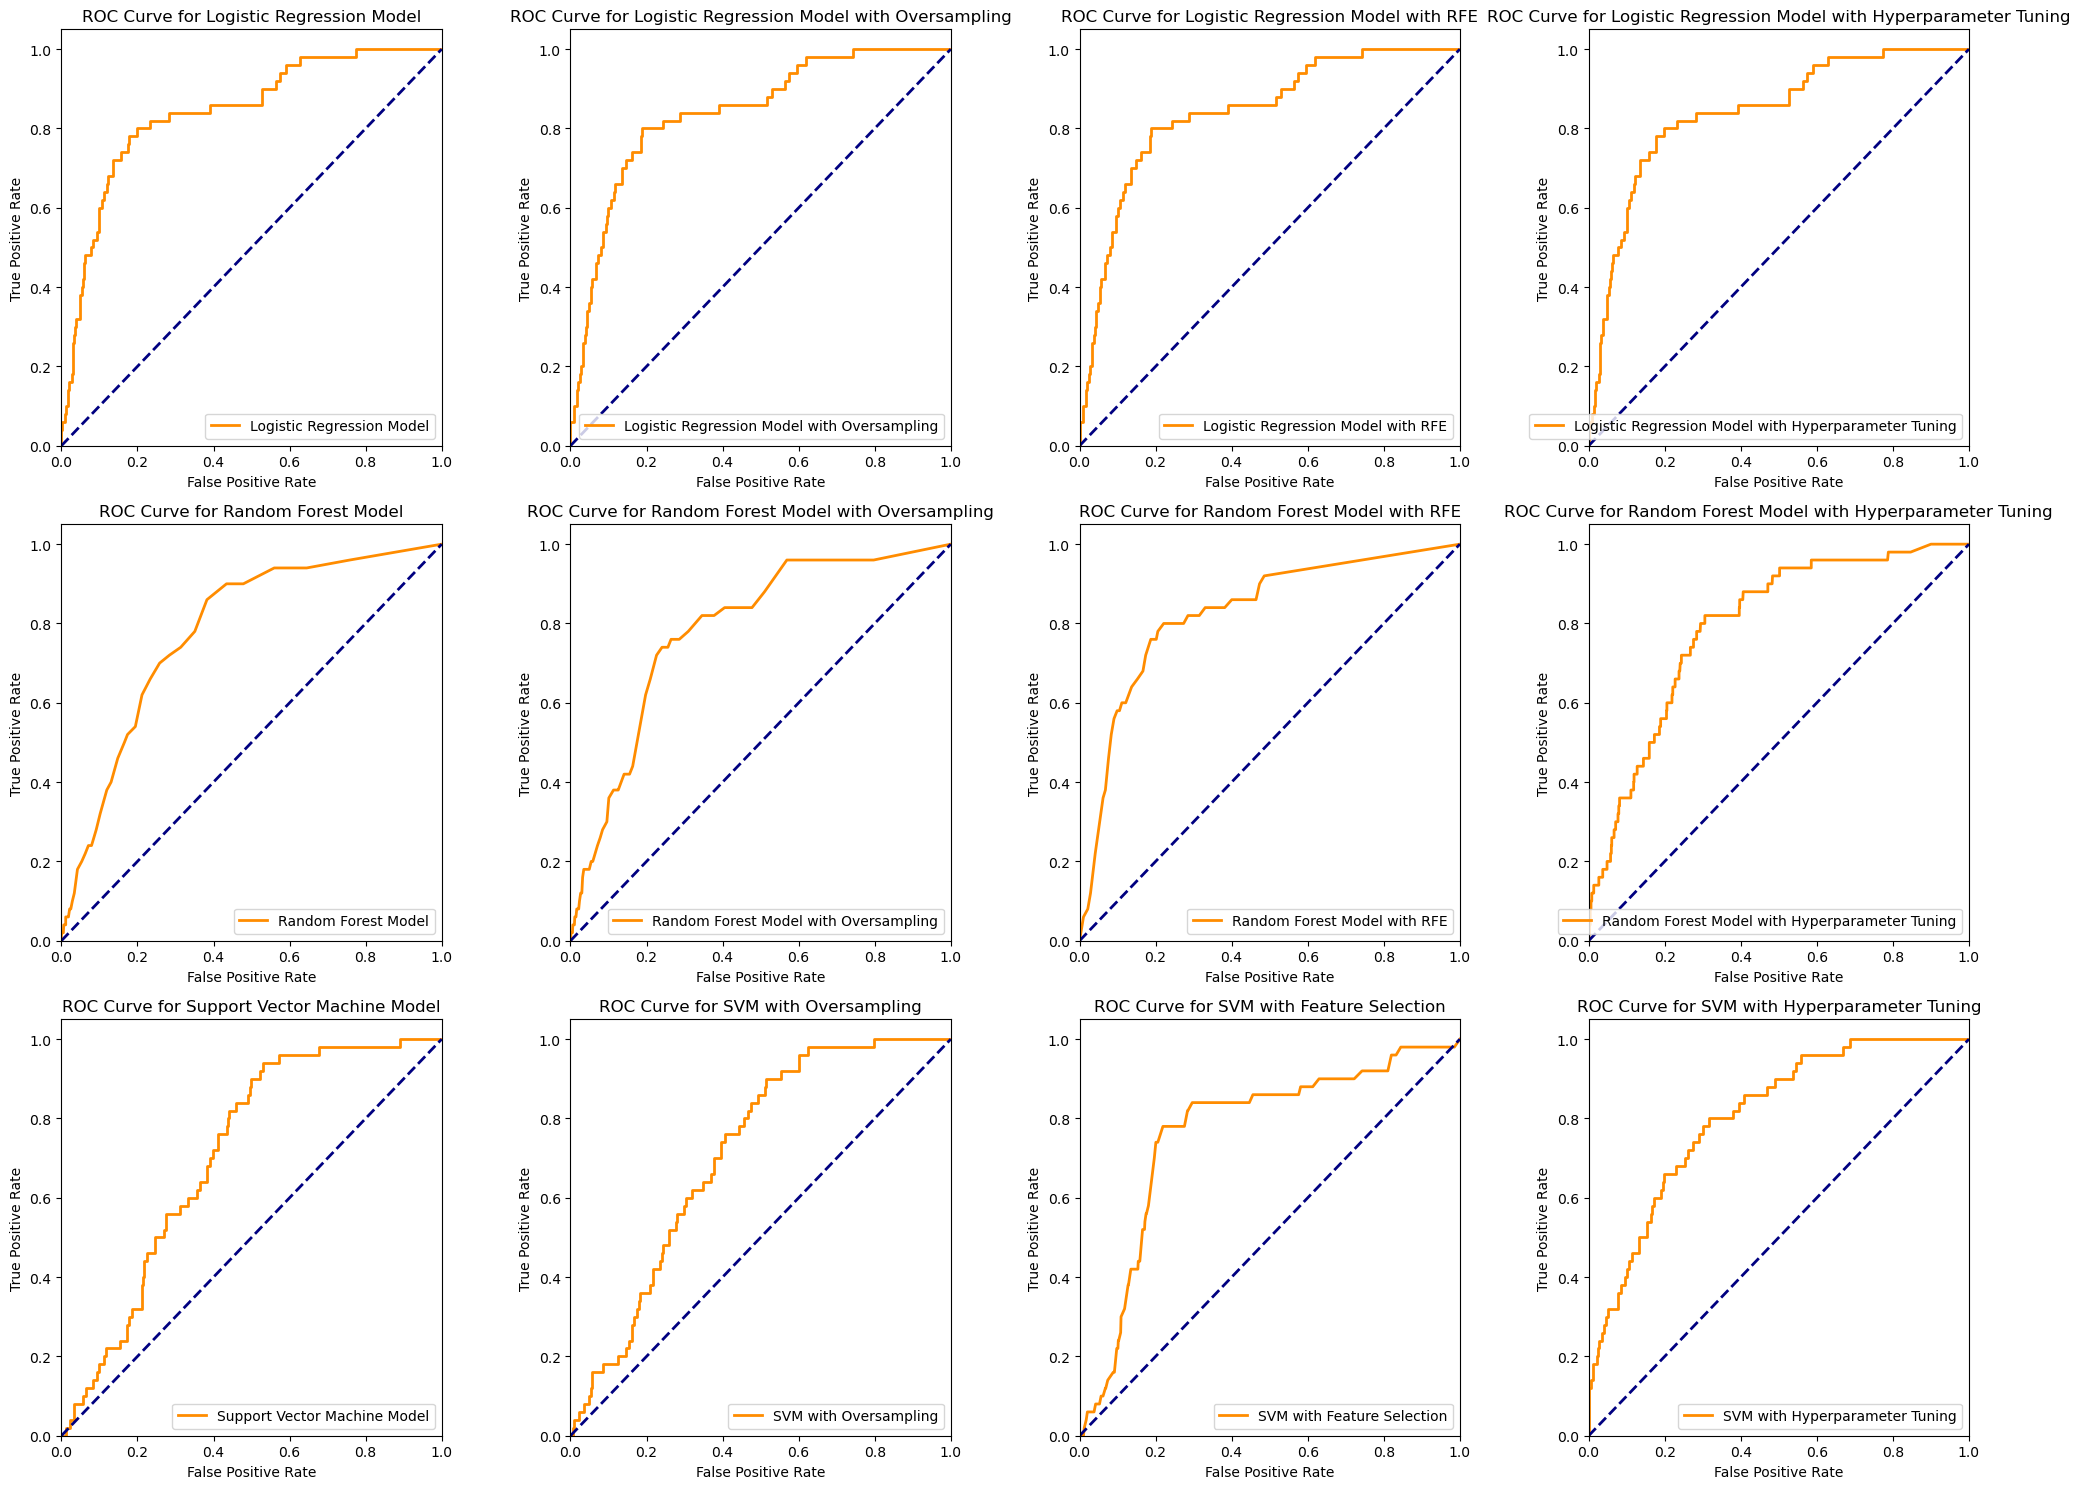

In [696]:
# List of all ROC curves
roc_curves = [roc_curves_log, roc_curves_rf, roc_curves_svm]

# Create subplots: 3 rows (models) and 4 columns (variations)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Titles for each row
model_titles = ['Logistic Regression', 'Random Forest', 'Support Vector Machine']

# Plot each ROC curve
for row, (model_roc_curves, model_title) in enumerate(zip(roc_curves, model_titles)):
    for col, roc in enumerate(model_roc_curves):
        ax = axes[row, col]
        ax.plot(roc['fpr'], roc['tpr'], color='darkorange', lw=2, label=roc['label'])
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {roc["label"]}')
        ax.legend(loc='lower right')

# Add title and Adjust layout to prevent overlap
display(HTML(f"<h4>ROC Curves for all Models </h4>"))
plt.tight_layout()
plt.show()

In [697]:
# Combine all classification reports
df_auc_all = pd.concat([df_auc_log, df_auc_rf, df_auc_svm], ignore_index=True)

# Sort the combined DataFrame by the 'Precision' column in descending order
df_auc_sorted = df_auc_all.sort_values(by='AUC', ascending=False)

# Reset the index to maintain consistency after sorting
df_auc_sorted.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame as an HTML table
display(HTML(f"<h4>Area under the curve for all Models )</h4>"))
display(df_auc_sorted)

,Model,AUC
0,Logistic Regression Model,0.842819
1,Logistic Regression Model with Hyperparameter ...,0.842819
2,Logistic Regression Model with Oversampling,0.842243
3,Logistic Regression Model with RFE,0.842243
4,Random Forest Model with RFE,0.827058
5,Support Vector Machine Model with Hyperparamet...,0.806790
6,Random Forest Model with Hyperparameter Tuning,0.793601
7,Random Forest Model with Oversampling,0.782006
8,Random Forest Model,0.778889
9,Support Vector Machine Model with Feature Sele...,0.764259


##### Comment

When comparing the ROC's for each model, we can see that the Logistic Regression Models and Random Forest Models perform better than the Support Vector Machine Models on this metric. Best performing, visually, would be the Logistic Regression Model with Hyperparameter Tuning and the Random Forest Model with Hyperparameter Tuning.

Comparing this impression with the actual AUC's, based on them we would chose the basic Logistic Regression Model and the Logisitc Regression Model with Hyperparameter Tuning, since both have an AUC of 0.84. 

Moderate performers would be the Random Forest Model with RFE (0.83) and the Support Vector Machine with Hyperparameter Tuning (0.81).

### Final Comparison and Model Selection

Now that we compared all our models and metrics, we need to chose the best fitting model for our data.

I decided against using the Brier Score or AUC for my primary metrics, since I'm more interested in balancing the minority class performance. I want to do this because I want a balance between precision and recall for my stroke prediction.

When we want to incorporate all metrics when choosing our model, our best general performer over all of them is the Random Forest with Feature Selection with a high F1-Score for the minorty class (0.23), a decent accuracy (0.75) and a relatively good Brier Score (0.163).

However, since this model only uses one predictor variable ('age'), I would rather choose the second best general perforimg model which would be the Random Forest Model with Hyperparameter Tuning.
This model has the second highest F1-Score for the minority group (0.21), a high accuracy (0.87), a relatively low Brier Score (0.091) and a moderate AUC (0.79).

Additionally, Random Forest Models are inherently good at handling imbalanced data well, especially when incorporating hyperparameter tuning.
Therefore, the Random Forest Model with Hyperparameter Tuning is my best model.

# Diagnosis Stroke - Conclusion and Reccomendations

After doing all this, here are some thoughts I still have on this dataset and my approach.

If I wanted to refine my model(s) further, I would try the following steps:
1. A different z-score (of 2.5 or even lower) for removing outliers.
2. Removing outliers in the Average Glucose Level variable
3. Combining adjustments (e.g. Feature Selection + Hyperparameter Tuning)

However, the variables in the data set may be lacking in predictive / informative value and lead to these moderate performing models overall.
I would be interested in other variables and their influence on the model, such as symptoms, family history, other indicators of vascular health (Cholesterol, Blood Pressure) and optionally medications.

# Sources

Arboix, A. (2015). Cardiovascular risk factors for acute stroke: Risk profiles in the different subtypes of ischemic stroke. World Journal Of Clinical Cases, 3(5), 418. https://doi.org/10.12998/wjcc.v3.i5.418 

Joundi, R. A., Patten, S. B., Williams, J. V. & Smith, E. E. (2022). Vascular risk factors and stroke risk across the life span: A population-representative study of half a million people. International Journal Of Stroke, 17(9), 1021–1029. https://doi.org/10.1177/17474930211070682